In [1]:
import utils
import importlib
importlib.reload(utils)
import time
import os
import joblib
import evaluate
importlib.reload(evaluate)
from evaluate import accuracy, compute_PR
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load Dataset
Inputs have been preprocessed using SMILES, Mordred, and output parsing in the "notebooks" directory. The resulting datasets were saved to the "data" directory, which were removed before publishing for copyright purposes. 

In [2]:
start_time = time.time()

# Create pandas dataframes from X and y datasets
# Check location of X and y datasets before running
# URLs were redacted for copyright purposes
X_url = ''
y_url = ''
X_full = pd.read_csv(X_url, index_col='Unnamed: 0')
y_full = pd.read_csv(y_url, index_col='Unnamed: 0')
print(time.time() - start_time)

2297.787873029709


In [3]:
# View datasets
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9,yield
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379,0.09
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903,0.07
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379,0.21
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379,0.30
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903,0.88
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903,0.91
134634,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.000000,0,0.444082,0.0,0,0,0.000000,0,11.126903,0.89
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379,0.93


In [4]:
# Remove unnecessary columns
X_full = X_full.drop(columns=[i for i in X_full.columns if 'Unnamed:' in str(i)])
X_full = X_full.drop(columns=[i for i in X_full.columns if str(i) in ['0_y', '0.09']])
X_full = X_full.drop(['yield'], axis=1)
y_full = y_full.drop(columns=[i for i in y_full.columns if 'Unnamed:' in str(i)])

# View changes
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,3,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,2,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,1,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903
134634,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0,0.000000,0,0.444082,0.0,0,0,0.000000,0,11.126903
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,0,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379


In [5]:
y_full

,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,reagent_108,reagent_109,reagent_110,reagent_111,reagent_112,null_metals,null_ligands,null_bases,null_solvents,null_additives
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
134633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
134634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
134635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


# Creating full GBM models
## SMILES + Descriptors

### Split dataset

In [6]:
# Test indices were chosen randomly in GCN experiments
# and used here for consistency
# Make sure to set this correctly and verify this!
test_path = '../../data/suzuki_Y_test_labeled.csv'
test_labels = pd.read_csv(test_path, index_col='Unnamed: 0')
test_labels

,pred_M,pred_L,pred_B,pred_S,pred_A
8,['M2'],['L1'],['B5'],"['S2', 'S4', 'S9']",['Null']
28,['M2'],['L1'],['B2'],"['S5', 'S9']",['Null']
29,['M2'],['L1'],['B2'],"['S5', 'S9']",['Null']
65,['M1'],['Null'],['B5'],"['S2', 'S5', 'S9']",['Null']
100,['M2'],['L1'],['B2'],"['S5', 'S9']",['A4']
...,...,...,...,...,...
134607,['Null'],['Null'],['B13'],['S9'],['Null']
134614,['Null'],['Null'],['B1'],['S9'],['Null']
134615,['Null'],['Null'],['B1'],['S9'],['Null']
134629,['Null'],['Null'],['B1'],['Null'],['Null']


In [7]:
# Get indices of test reactions
test_inds = test_labels.index.values
print(len(test_inds))

12831


In [8]:
# Split full dataset based on test indices
X_train = X_full[~X_full.index.isin(test_inds)]
y_train = y_full[y_full.index.isin(X_train.index)]
X_test = X_full[X_full.index.isin(test_inds)]
y_test = y_full[y_full.index.isin(test_inds)]

# Check sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((116505, 2304), (116505, 118), (12831, 2304), (12831, 118))

## Construct label trellis

In [9]:
def learn_dep_matrix(df):
    """
    Construct dependency matrix given a dataframe of label vectors
    
    ARGUMENTS
        (pandas DataFrame)df: dataframe of label vectors
        
    RETURNS
        (np.array)mat: dependency matrix containing mutual information
                       for all label pairs
    """
    # Initialize empty square matrix
    mat = np.zeros((len(df.columns), len(df.columns)))
    
    # Iterate over each label pair combination and fill in matrix
    # positions with their mutual info scores
    for i, col in enumerate(df.columns):
        for j, other_col in enumerate(df.columns):
            if j < i:
                mat[i, j] = mat[j, i]
            else:
                mat[i, j] = mutual_info_score(df[col], df[other_col])
    return mat

In [10]:
# Construct dependency matrix of output label correlations
start_time = time.time()
dep_matrix = learn_dep_matrix(y_train)
print(time.time() - start_time)
print(dep_matrix.shape)

52.99919581413269
(118, 118)


In [11]:
def form_trellis(df, mat, first_reagent=0):
    """
    Construct trellis grid based on dependency matrix to be used for ordering
    chained classifiers. See algorithm from Read et al. Pattern Recognition
    2015, 48, 6, 2096-2109. DOI: 10.1016/j.patcog.2015.01.004. Also found at
    http://arxiv.org/abs/1501.04870
    
    ARGUMENTS:
        (pandas DataFrame)df: dataframe of output vectors containing labels
                                to be fit into trellis
        (np.array)mat: dependency matrix containing label-pair mutual
                        information scores
        (int)first_reagent: label index to initialize trellis ordering
        
    RETURNS:
        (list)struct: list of list of tuples. high-level list contains each
                        row of the trellis as sub-list. rows contain each entry
                        as a tuple of the: (label index from the dataset 
                        dictionary, label name, mutual info score)
    """
    # Set up empty square grid to construct trellis
    col_set = set(df.columns)
    n_cols = len(df.columns)
    width = int(np.ceil(np.sqrt(n_cols)))
    struct = [[None for _ in range(width)] for _ in range(width)]
    
    # Iterate through trellis grid filling in labels
    for row in range(width):
        for col in range(width):
            if len(col_set) == 0:
                break
            # Set top-left label as specified first_reagent
            elif row == 0 and col == 0:
                struct[row][col] = (first_reagent, df.columns[first_reagent], 0)
            # Calculate combined mutual info scores between remaining labels
            # and labels in available trellis directions (from Read
            # et al., models take input from positions up, left, and 
            # up-left of the current bin, unless those directions extend
            # out of the grid)
            else:
                scores = np.zeros(n_cols)
                if row - 1 >= 0:
                    scores += mat[struct[row - 1][col][0]]
                if col - 1 >= 0:
                    scores += mat[struct[row][col - 1][0]]
                if row - 1 >= 0 and col - 1 >= 0:
                    scores += mat[struct[row - 1][col - 1][0]]
                
                # Fill in current position with the label that maximizes the
                # summed mutual info score with the upstream bins
                scored_cols = list(zip(range(n_cols), df.columns, scores))
                ranked_cols = sorted(scored_cols, key=lambda x: x[2], reverse=True)
                for i, ranked_col, score in ranked_cols:
                    if ranked_col in col_set:
                        #print(i, ranked_col, score)
                        struct[row][col] = (i, ranked_col, score)
                        break
            #print(row, col, struct[row][col])
            col_set.remove(struct[row][col][1])
    return struct

In [12]:
# Create trellis grid from output vectors and their dependency matrix
start_time = time.time()
struct = form_trellis(y_train, dep_matrix)

# View top row of the trellis
print(time.time() - start_time)
print(struct[0])

0.00783991813659668
[(0, 'reagent_0', 0), (113, 'null_metals', 0.09650904628180546), (1, 'reagent_1', 0.022812433837528984), (114, 'null_ligands', 0.08889753269958597), (28, 'reagent_28', 0.06987228837924188), (2, 'reagent_2', 0.0027099688562799438), (89, 'reagent_89', 0.014155960259334771), (92, 'reagent_92', 0.05330984602606755), (87, 'reagent_87', 0.05239749030992438), (86, 'reagent_86', 0.0170198805776459), (90, 'reagent_90', 0.013595484817419907)]


In [13]:
# View trellis 
id_trellis = [[reagent[0] if type(reagent) == tuple else reagent for reagent in row] for row in struct]
id_trellis_df = pd.DataFrame(id_trellis)
id_trellis_df

,0,1,2,3,4,5,6,7,8,9,10
0,0,113,1,114,28,2,89,92,87.0,86.0,90.0
1,4,3,52,51,53,29,116,94,91.0,35.0,59.0
2,5,30,54,115,55,31,12,49,56.0,65.0,33.0
3,34,40,10,58,117,96,20,63,50.0,11.0,13.0
4,76,7,64,26,98,99,88,78,39.0,106.0,36.0
5,41,32,104,61,72,57,9,68,66.0,48.0,60.0
6,75,8,6,112,15,23,101,46,18.0,47.0,17.0
7,14,80,73,81,37,100,77,62,22.0,95.0,69.0
8,85,71,16,109,70,67,42,74,38.0,103.0,19.0
9,43,25,102,45,105,107,44,108,83.0,21.0,110.0


In [14]:
# View dependency matrix
pd.DataFrame(dep_matrix).round(3)

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,0.671,0.061,0.047,0.032,0.033,0.018,0.005,0.004,0.003,0.003,...,0.000,0.001,0.000,0.000,0.000,0.097,0.054,0.001,0.004,0.002
1,0.061,0.356,0.012,0.008,0.008,0.004,0.001,0.001,0.001,0.001,...,0.000,0.000,0.000,0.001,0.000,0.023,0.089,0.000,0.001,0.000
2,0.047,0.012,0.307,0.006,0.006,0.003,0.001,0.001,0.001,0.001,...,0.000,0.000,0.000,0.000,0.000,0.018,0.009,0.000,0.001,0.000
3,0.032,0.008,0.006,0.236,0.004,0.002,0.001,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.012,0.006,0.000,0.000,0.001
4,0.033,0.008,0.006,0.004,0.236,0.002,0.001,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.012,0.002,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.097,0.023,0.018,0.012,0.012,0.007,0.002,0.001,0.001,0.001,...,0.000,0.000,0.000,0.000,0.000,0.456,0.008,0.003,0.003,0.003
114,0.054,0.089,0.009,0.006,0.002,0.039,0.000,0.005,0.001,0.001,...,0.000,0.000,0.000,0.000,0.000,0.008,0.376,0.000,0.000,0.000
115,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.001,0.000,0.000,0.003,0.000,0.128,0.001,0.001
116,0.004,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.001,0.000,0.000,0.000,0.003,0.000,0.001,0.274,0.001


In [15]:
def convert_2d_tuples_to_lists(struct):
    """
    Converts tuples to lists within trellis structure. Expands None type
    entries to lists of None for compatability
    
    ARGUMENTS:
        (list)struct: trellis structure as list of list of tuples
        
    RETURNS:
        (list): list of list of lists
    """
    return [[list(cell) if cell is not None else [None, None, None]  for cell in row] for row in struct]

In [16]:
# Convert trellis tuples to lists
struct_lists = convert_2d_tuples_to_lists(struct)

# Create trellis arrays containing indices and scores only
reagent_id_struct = np.array(struct_lists)[:,:,0]
reagent_score_struct = np.array(struct_lists)[:,:,2]

In [17]:
n_metals = 28
n_ligands = 23
n_bases = 35
n_solvents = 10
n_additives = 17

cutoffs = [
    0,
    n_metals,
    n_metals + n_ligands,
    n_metals + n_ligands + n_bases,
    n_metals + n_ligands + n_bases + n_solvents,
    n_metals + n_ligands + n_bases + n_solvents + n_additives
]
category_names = [
    'metals', 'ligands', 'bases', 'solvents', 'additives'    
]

category_initials = [
    'M', 'L', 'B', 'S', 'A'    
]

In [18]:
cutoffs

[0, 28, 51, 86, 96, 113]

In [19]:
def reagent_id_to_label(reagent_id, cutoffs, category_initials):
    """
    Creates named bin labels as appear in the manuscript in the format
    {category_initial}{index}
    
    ARGUMENTS:
        (int)reagent_id: reagent index from dataset dictionary
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each category
                                ordered to match cutoffs
        
    RETURNS:
        (str): shorthand label for the reagent 
    """
    if reagent_id is None:
        return None
    # Handle null labels added at end of dictionary
    if reagent_id >= cutoffs[-1]:
        return category_initials[reagent_id - cutoffs[-1]] + "_NULL"
    for i, cutoff in enumerate(cutoffs):
        if reagent_id < cutoff:
            #print(reagent_id, cutoff, i)
            return category_initials[i - 1] + str(reagent_id - cutoffs[i - 1] + 1)

In [20]:
# Re-make trellis with fully labelled bins 
reagent_label_struct = np.empty(id_trellis_df.shape).astype(str)
for i in range(id_trellis_df.shape[0]):
    for j in range(id_trellis_df.shape[1]):
        reagent_label_struct[i, j] = reagent_id_to_label(
            (id_trellis[i][j]), cutoffs, category_initials
        )

In [21]:
# View trellis as labelled dataframe
reagent_label_struct_df = pd.DataFrame(reagent_label_struct)
reagent_label_struct_df

,0,1,2,3,4,5,6,7,8,9,10
0,M1,M_NULL,M2,L_NULL,L1,M3,S4,S7,S2,S1,S5
1,M5,M4,B2,B1,B3,L2,S_NULL,S9,S6,L8,B9
2,M6,L3,B4,B_NULL,B5,L4,M13,L22,B6,B15,L6
3,L7,L13,M11,B8,A_NULL,A1,M21,B13,L23,M12,M14
4,B26,M8,B14,M27,A3,A4,S3,B28,L12,A11,L9
5,L14,L5,A9,B11,B22,B7,M10,B18,B16,L21,B10
6,B25,M9,M7,A17,M16,M24,A6,L19,M19,L20,M18
7,M15,B30,B23,B31,L10,A5,B27,B12,M23,S10,B19
8,B35,B21,M17,A14,B20,B17,L15,B24,L11,A8,M20
9,L16,M26,A7,L18,A10,A12,L17,A13,B33,M22,A15


In [22]:
# View trellis scores as dataframe
reagent_score_struct_df = pd.DataFrame(reagent_score_struct)
reagent_score_struct_df

,0,1,2,3,4,5,6,7,8,9,10
0,0,0.096509,0.0228124,0.0888975,0.0698723,0.00270997,0.014156,0.0533098,0.0523975,0.0170199,0.0135955
1,0.0328642,0.0485474,0.0240507,0.144962,0.0717616,0.0168514,0.0256456,0.0917116,0.0123338,0.00923126,0.00680106
2,0.00235871,0.00896695,0.0313694,0.0237358,0.0140298,0.0078075,0.00545112,0.0141386,0.00396744,0.00304288,0.00406034
3,0.00681962,0.0036496,0.002436,0.00158281,0.00228702,0.0669357,0.000947696,0.00018278,0.000755021,0.000701978,0.000680573
4,0.00107861,0.000182085,0.000940777,0.00168603,0.0183033,0.017265,0.00108251,0.00084551,0.00016174,0.000657367,0.000576224
5,4.60463e-05,0.000386846,0.000200998,0.00115358,0.000893108,0.000774858,0.000562969,0.00097936,0.000263246,9.15113e-05,0.000275279
6,4.44206e-05,0.000164193,0.000112455,0.000672871,0.000912332,0.000505879,0.000618809,0.00187309,0.000835371,0.000211654,0.000181511
7,7.74084e-06,0.00150827,0.00041196,0.000295157,2.56658e-05,0.000116241,0.000526528,3.02869e-05,0.000372981,5.41167e-05,0.000130252
8,0.000791008,9.31351e-05,4.7963e-05,1.21139e-05,0.000433024,2.475e-05,6.9072e-05,3.24765e-05,3.70448e-05,1.00124e-05,0.00836939
9,1.00847e-06,0.00286574,5.52597e-06,5.72162e-06,5.81574e-06,2.08657e-05,6.05848e-06,3.68259e-05,6.95187e-06,5.40037e-06,6.35367e-05


In [23]:
# Save trellises
reagent_label_struct_df.to_csv('suzuki_trellis_label_struct.csv', index=True)
reagent_score_struct_df.to_csv('suzuki_trellis_score_struct.csv', index=True)

# Train GBM classifiers
## Binary relevance method (BM)

In [24]:
def train_lgbm_classifier(X_train, y_train, model_file_name):
    """
    Trains one LightGBM binary classifier for every bin in the label space
    under multi-label classification approach
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        (str)model_file_name: name of model file to be saved (should be
                                full string with file type)
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    # Initialize classifier
    clf = OneVsRestClassifier(LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    ))
    
    # Fit classifier and save model
    clf.fit(X_train, y_train)
    joblib.dump(clf, model_file_name)
    return clf

In [25]:
def get_top_k_preds(y_pred_proba, cutoffs, category_initials,
                    k=3, include_nulls=True):
    """
    Get top-k predicted rankings for reagents in each dictionary category
    
    ARGUMENTS:
        (array)y_pred_proba: predicted probability vectors for example set 
        (int)k: top-k ranking limit to be assessed
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: make prediction on null labels, i.e., absence 
                                of a label from each category
                                    
    RETURNS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["pred_" + initial for initial in category_initials]
    all_preds = []
    
    # Create categorical rankings for each reaction in prediction set 
    for row in range(len(y_pred_proba)):
        reaction_preds = []
        for i in range(len(cutoffs) - 1):
            category_preds = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            preds = y_pred_proba[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_pred = y_pred_proba[row][cutoffs[-1]+i]
                preds = np.hstack((preds, null_pred))
                
            # Find indices of top-k predicted labels
            top_k_preds_inds = np.argsort(-preds)[:k]
            
            # Create final list for category
            for ind in top_k_preds_inds:
                if ind == num_category_labels:
                    category_preds.append('Null')
                else:
                    category_preds.append(category_initials[i] + str(ind + 1))
                    
            # Add category predictions to reaction prediction set
            reaction_preds.append(category_preds)
        
        # Add reaction predictions to full set
        all_preds.append(reaction_preds)
    
    # Fill in dataframe
    preds_df = pd.DataFrame(all_preds, columns=columns)
    return preds_df

def get_type_count(cutoffs, category_initials):
    """
    Returns dictionary with the number of labels in each dataset category
    
    ARGUMENTS:
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
    RETURNS:
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    """
    # Create dictionary from category initials and cutoffs
    type_count = {
        category_initials[i]: cutoffs[i+1] - cutoffs[i] + 1 
        for i in range(len(category_initials))
}
    return type_count

In [26]:
def label_ground_truth(gt_df, cutoffs, category_initials, include_nulls=True):
    """
    Convert ground truth (gt) label arrays to same format as predictions
    
    ARGUMENTS:
        (pd.DataFrame)gt_df: dataframe of output vectors for test set
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: whether null labels, i.e., absence of a label
                                from each category are explicitly included
                                in output vectors
                                    
    RETURNS:
        (pd.DataFrame)gt_labeled_df: dataframe of predicted rankings for each 
                                        category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["gt_" + initial for initial in category_initials]
    all_outputs = []
    
    # Create category labels for each reaction in test set 
    gt_array = gt_df.values
    for row in range(len(gt_array)):
        reaction_labels = []
        for i in range(len(cutoffs) - 1):
            category_labels = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            gt_labels = gt_array[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_label = gt_array[row][cutoffs[-1]+i]
                gt_labels = np.hstack((gt_labels, null_label))
                
            # Find indices of positive labels
            gt_inds = np.where(gt_labels)[0]
            
            # Create final list for category
            for ind in gt_inds:
                if ind == num_category_labels:
                    category_labels.append('Null')
                else:
                    category_labels.append(category_initials[i] + str(ind + 1))
                    
            # Add category labels to reaction label set
            reaction_labels.append(category_labels)
        
        # Add reaction labels to full set
        all_outputs.append(reaction_labels)
    
    # Fill in dataframe
    gt_labeled_df = pd.DataFrame(all_outputs, columns=columns)
    return gt_labeled_df

def format_results_for_metrics(preds_df, gt_df, type_count, category_initials):
    """
    Convert output dataframes to lists containing predicted and ground 
    truth (gt) labels to be evaluated using accuracy metric functions
    ARGUMENTS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set 
                                (see get_top_k_preds)
        (pd.DataFrame)gt_df: dataframe of gt rankings for each category over
                                the example set (see get_top_k_preds)
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    RETURNS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
    """
    # Set empty list
    formatted_test = []
    
    # Iterate through reactions 
    for ind in preds_df.index:
        # Set reaction dictionary for predicted and gt labels
        row_result = {
            'id': ind,
            'pred': {
                initial: [] for initial in category_initials
            },
            'gt': {
                initial: [] for initial in category_initials
            }
        }

        # Iterate through categories and update prediction dictionary
        for i, vals in enumerate(preds_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['pred'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['pred'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Iterate through categories and update gt dictionary
        for i, vals in enumerate(gt_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['gt'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['gt'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Add row result to full set         
        formatted_test.append(row_result)
    return formatted_test

def get_metrics_dict(formatted_test, type_count, data_file_name):
    """
    Calculate model performance metrics by comparing ground truth (gt) and
    predicted labels and return results file
    
    ARGUMENTS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
        (str)data_file_name: name of model file to be saved (should be
                                full string with file type .json ending)
    RETURNS:
        (dict)metrics_dict: list containing gt labels and predicted rankings
                            to be evaluated with accuracy metric functions
    """
    top_1_acc, top_k_acc = accuracy(formatted_test, type_count)
    result = compute_PR(formatted_test, type_count)
    (PCP, PCR, AP, AR, OVP, OVR), (PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk)  = result
    metric_keys = [
        'PCP', 'PCR', 'AP', 'AR', 'OVP', 'OVR',
        'PCP_topk', 'PCR_topk', 'AP_topk', 'AR_topk', 'OVP_topk', 'OVR_topk',
        'top_1_acc', 'top_k_acc'
    ]
    metric_values = [
        PCP, PCR, AP, AR, OVP, OVR,
        PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk,
        top_1_acc, top_k_acc
    ]
    metrics_dict = {key: value for key, value in zip(metric_keys, metric_values)}
    with open(data_file_name, 'w') as data_file:
        json.dump(metrics_dict, data_file)
    return metrics_dict

In [33]:
# Train BM-GBMs on CN training data
start_time = time.time()
suzuki_bm_gbms_file = 'suzuki_bm_gbms.model.joblib'
suzuki_bm_gbms = train_lgbm_classifier(X_train, y_train, suzuki_bm_gbms_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 5012.293637037277 s


In [34]:
# Make predictions with trained model
start_time = time.time()
full_bm_gbm_preds = suzuki_bm_gbms.predict_proba(X_test)
print(f'Testing complete. Testing time: {time.time()-start_time} s')

Testing complete. Testing time: 109.519211769104 s


In [35]:
# Get top-k predicted rankings from prediction set
full_bm_preds_labeled = get_top_k_preds(
    full_bm_gbm_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
full_bm_formatted_results = format_results_for_metrics(
    full_bm_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
full_bm_metrics = get_metrics_dict(
    full_bm_formatted_results, type_count, 'full_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
full_bm_top_1_acc = full_bm_metrics['top_1_acc']
full_bm_top_3_acc = full_bm_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.5732211051359988
Top 3 accuracy for type  M  : 0.8516093835242772
Top 1 accuracy for type  L  : 0.8389837113241368
Top 3 accuracy for type  L  : 0.9635258358662614
Top 1 accuracy for type  B  : 0.4908424908424908
Top 3 accuracy for type  B  : 0.8337619826981529
Top 1 accuracy for type  S  : 0.6729015665185878
Top 3 accuracy for type  S  : 0.8636895019873744
Top 1 accuracy for type  A  : 0.9258826280102875
Top 3 accuracy for type  A  : 0.9841789416257501


### Feature importances

In [36]:
num_estimators = len(suzuki_bm_gbms.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(suzuki_bm_gbms.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('suzuki_full_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['201', '6', '9', '11', '10', '110', '0', '7', '5', '13', '4', '16',
       '210', '1', '12', '3', '14', '111', '8', '15'],
      dtype='object')
Index(['201', '6', '9', '11', '10', '110', '0', '7', '5', '13', '4', '16',
       '210', '1', '12', '3', '14', '111', '8', '15'],
      dtype='object')
Index(['product_JGI6', 'product_JGI3', 'product_JGI5', 'rdfred_1_JGI3',
       'rdfred_1_AATSC0p', 'rdfred_2_SsOH', 'rdfred_1_IC1', 'product_JGI4',
       'product_SdssC', 'rdfred_1_ATSC3m', 'rdfred_1_EState_VSA6',
       'rdfred_1_SdssC', 'product_JGI9', 'product_ATSC4i', 'rdfred_2_SdssC',
       'product_SlogP_VSA8', 'product_JGI2', 'product_JGI8',
       'product_PEOE_VSA8', 'product_SsOH'],
      dtype='object')


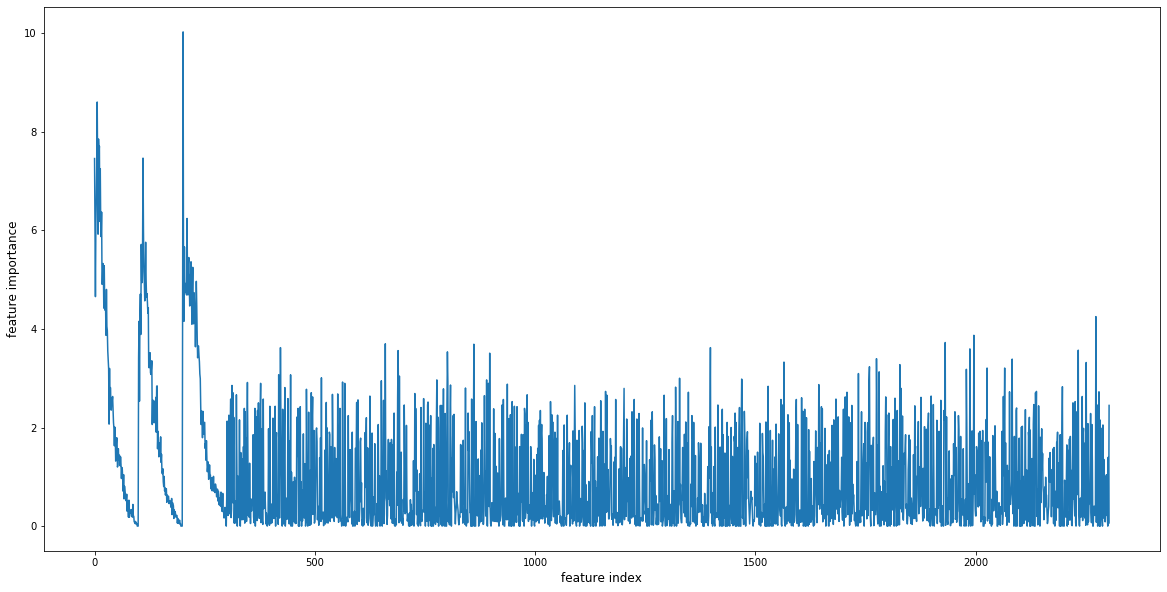

In [37]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=12)
plt.ylabel('feature importance', fontsize=12)
plt.savefig('suzuki_full_bm_fis.png', dpi=100)

In [38]:
plt.close()

## Adversarial controls

In [27]:
# View current training set
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,3,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,2,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,1,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,67.0,108.0,67.0,49.0,61.0,67.0,78.0,61.0,67.0,67.0,...,0,1.879398,0,0.156780,0.0,0,0,0.000000,0,0.000000
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,0,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379


### Shuffle inputs, leaving outputs the same (shuffle inputs)
Trains model on fake reactions, testing on same test set of real ones

In [28]:
# Shuffle row ordering removing index
X_train_shuffle = np.random.permutation(X_train.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_shuffle_inputs = pd.DataFrame(
    X_train_shuffle, index=X_train.index, columns=X_train.columns
)

# View new dataframe (can see inputs have changed)
X_train_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,40.0,67.0,67.0,...,0.0,0.000000,1.0,0.338005,0.0,0.0,0.0,0.000000,0.0,26.630709
1,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,50.0,...,0.0,6.171926,0.0,0.872018,0.0,0.0,0.0,0.000000,0.0,28.572234
2,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,1.0,27.589196,0.0,0.831020,0.0,0.0,0.0,11.814359,0.0,17.006891
3,67.0,67.0,49.0,40.0,67.0,41.0,79.0,66.0,40.0,79.0,...,0.0,0.000000,0.0,0.344490,0.0,0.0,0.0,0.000000,0.0,16.876415
4,67.0,67.0,49.0,40.0,67.0,41.0,79.0,66.0,40.0,79.0,...,0.0,0.000000,0.0,0.110295,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,1.0,1.926807,0.0,0.709569,0.0,0.0,0.0,11.690425,0.0,11.126903
134632,79.0,67.0,40.0,67.0,67.0,40.0,66.0,114.0,41.0,61.0,...,0.0,0.000000,0.0,0.912834,0.0,0.0,0.0,5.687386,0.0,11.126903
134633,67.0,67.0,40.0,67.0,41.0,79.0,67.0,40.0,61.0,79.0,...,0.0,14.364135,0.0,0.525714,0.0,0.0,0.0,0.000000,0.0,11.257379
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.000000,0.0,0.120816,0.0,0.0,0.0,0.000000,0.0,0.000000


In [29]:
# But indices have stayed the same
X_train_shuffle_inputs.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            134625, 134626, 134627, 134628, 134630, 134631, 134632, 134633,
            134635, 134636],
           dtype='int64', length=116505)

In [30]:
X_train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            134625, 134626, 134627, 134628, 134630, 134631, 134632, 134633,
            134635, 134636],
           dtype='int64', length=116505)

In [43]:
# Re-train and test model
start_time = time.time()
shuffle_inputs_file = 'shuffle_inputs_bm_gbm.model.joblib'
shuffle_inputs_bm_gbm = train_lgbm_classifier(
    X_train_shuffle_inputs, y_train, shuffle_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_inputs_bm_preds = shuffle_inputs_bm_gbm.predict_proba(X_test)

# Get top-k predicted rankings from prediction set
suffle_inputs_bm_preds_labeled = get_top_k_preds(
    shuffle_inputs_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_inputs_bm_formatted_results = format_results_for_metrics(
    suffle_inputs_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_inputs_bm_metrics = get_metrics_dict(
    shuffle_inputs_bm_formatted_results, type_count, 
    'shuffle_inputs_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_inputs_top_1_acc = shuffle_inputs_bm_metrics['top_1_acc']
shuffle_inputs_top_3_acc = shuffle_inputs_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 5737.448042154312 s
Top 1 accuracy for type  M  : 0.37978333723014573
Top 3 accuracy for type  M  : 0.6718104590445017
Top 1 accuracy for type  L  : 0.8536357259761516
Top 3 accuracy for type  L  : 0.9233886680695191
Top 1 accuracy for type  B  : 0.3071467539552646
Top 3 accuracy for type  B  : 0.7223131478450627
Top 1 accuracy for type  S  : 0.646325305899774
Top 3 accuracy for type  S  : 0.7996259060088847
Top 1 accuracy for type  A  : 0.9096718883952927
Top 3 accuracy for type  A  : 0.9739692931182293


### Feature importances

In [44]:
num_estimators = len(shuffle_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_inputs_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('suzuki_shuffle_inputs_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['product_JGI9', '10', 'product_JGI6', 'product_JGI7', 'product_JGI8',
       '13', '16', 'product_JGI5', '11', '12', 'product_JGI3', '14', '9',
       'product_JGI10', 'product_JGI4', 'product_ATSC2dv', '224', '226', '15',
       'product_ATSC5i'],
      dtype='object')
Index(['10', '13', '16', '11', '12', '14', '9', '224', '226', '15', '227',
       '225', '201', '115', '223', '220', '7', '17', '222', '221'],
      dtype='object')
Index(['product_JGI9', 'product_JGI6', 'product_JGI7', 'product_JGI8',
       'product_JGI5', 'product_JGI3', 'product_JGI10', 'product_JGI4',
       'product_ATSC2dv', 'product_ATSC5i', 'product_ATSC6i', 'product_ATSC7i',
       'product_EState_VSA7', 'product_ATSC8d', 'product_ATSC4i',
       'product_CIC3', 'product_JGI2', 'product_ATSC8i', 'product_PEOE_VSA7',
       'rdfred_1_JGI3'],
      dtype='object')


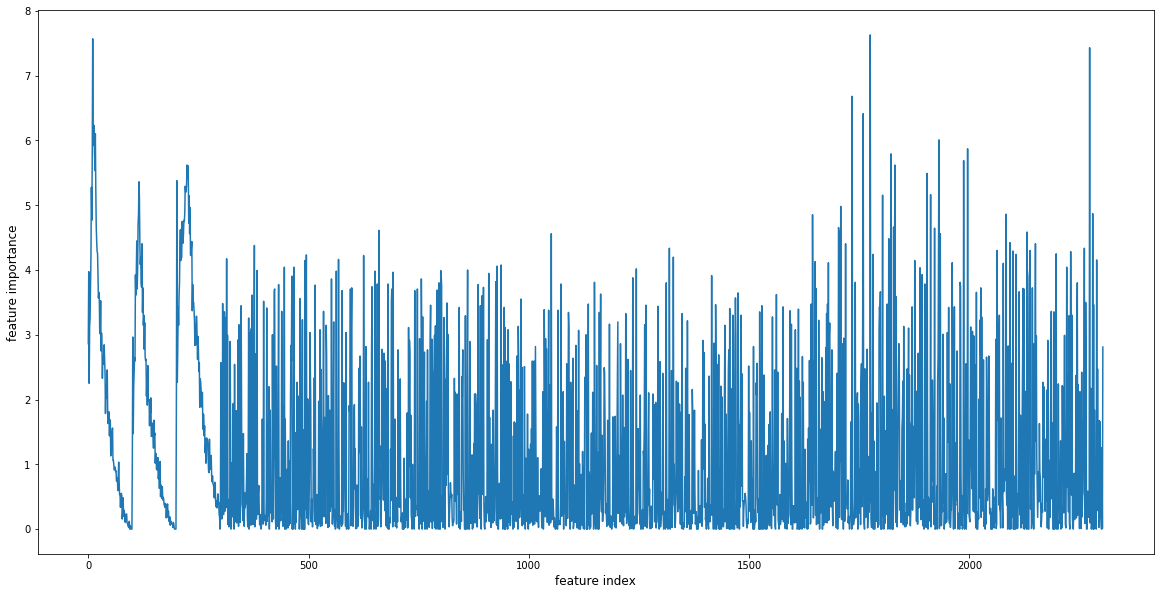

In [45]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=12)
plt.ylabel('feature importance', fontsize=12)
plt.savefig('suzuki_shuffle_inputs_bm_fis.png', dpi=100)

In [46]:
plt.close()

### Ablate SMILES region (Mordred only)

In [31]:
# Create new dataframe from only the Mordred input region
X_train_mordred = X_train[X_train.columns[300:]].copy()
X_test_mordred = X_test[X_test.columns[300:]].copy()
print(X_test_mordred.shape)

# View new dataframe (can see inputs have changed)
X_train_mordred

(12831, 2004)


,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,10,83.430800,4.591325,1,0,11.505249,5916.348144,0.0,4.431364e-01,-1.265689,...,3,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379
1,10,142.017485,4.187759,1,0,0.000000,7075.918101,0.0,1.419059e+00,-2.278748,...,2,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903
2,8,18.971829,4.388257,0,0,11.505249,4130.773394,0.0,1.901955e-01,-0.481514,...,1,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379
3,5,-58.349703,3.669951,0,0,4.603196,2222.145249,0.0,-1.332268e-15,0.363495,...,0,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379
4,4,-169.891933,3.621002,1,0,9.349867,1806.522986,0.0,0.000000e+00,0.935208,...,0,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,2,-96.192064,0.000000,0,0,0.000000,1491.142324,0.0,9.727653e-01,-0.388802,...,0,1.879398,0,0.156780,0.0,0,0,0.000000,0,0.000000
134632,11,31.813678,4.338923,1,0,19.944581,4631.144016,0.0,5.269603e-01,-1.769240,...,0,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903
134633,7,3.039573,3.766997,0,0,12.170333,3215.404570,0.0,3.377444e-01,-0.643624,...,0,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903
134635,11,50.778730,4.775967,1,0,21.880439,5293.709353,0.0,3.487811e-01,-1.016657,...,0,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379


In [48]:
# Re-train and test model
start_time = time.time()
mordred_only_file = 'mordred_only_bm_gbm.model.joblib'
mordred_only_bm_gbm = train_lgbm_classifier(
    X_train_mordred, y_train, mordred_only_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_only_preds = mordred_only_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
mordred_only_preds_labeled = get_top_k_preds(
    mordred_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_only_formatted_results = format_results_for_metrics(
    mordred_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
mordred_only_metrics = get_metrics_dict(
    mordred_only_formatted_results, type_count, 'mordred_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_only_top_1_acc = mordred_only_metrics['top_1_acc']
mordred_only_top_3_acc = mordred_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 4245.097455024719 s
Top 1 accuracy for type  M  : 0.47494349622009197
Top 3 accuracy for type  M  : 0.7996259060088847
Top 1 accuracy for type  L  : 0.8466214636427403
Top 3 accuracy for type  L  : 0.9533161873587406
Top 1 accuracy for type  B  : 0.44899072558647024
Top 3 accuracy for type  B  : 0.8138103031720053
Top 1 accuracy for type  S  : 0.6575481256332321
Top 3 accuracy for type  S  : 0.8375029226093056
Top 1 accuracy for type  A  : 0.8976697061803445
Top 3 accuracy for type  A  : 0.98339957914426


### Feature importances

In [49]:
num_estimators = len(mordred_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
mordred_only_average_fis = np.average(np.array(all_fis), axis=0)
sorted_mordred_only_fis = np.argsort(-mordred_only_average_fis)
mordred_only_fi_names = X_train_mordred.columns[sorted_mordred_only_fis]

mordred_only_fi_df = pd.DataFrame(
    list(zip(mordred_only_fi_names, 
             mordred_only_average_fis[sorted_mordred_only_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_only_fi_df.to_csv('suzuki_mordred_only_fis.csv')

top_mordred_only_fis = sorted_mordred_only_fis[:20]

top_mordred_only_fi_names = X_train_mordred.columns[top_mordred_only_fis]

print(top_mordred_only_fi_names)

Index(['rdfred_1_ATSC1m', 'product_JGI6', 'product_JGI4', 'product_JGI5',
       'rdfred_1_EState_VSA6', 'product_JGI8', 'rdfred_1_ATSC3m',
       'product_SdssC', 'rdfred_2_SdssC', 'rdfred_1_JGI3', 'rdfred_1_AATSC0p',
       'product_ATSC2dv', 'product_JGI7', 'product_JGI3', 'rdfred_1_AATSC0i',
       'rdfred_1_SsCl', 'rdfred_2_JGI3', 'rdfred_1_SdssC', 'rdfred_2_SsOH',
       'product_JGI2'],
      dtype='object')


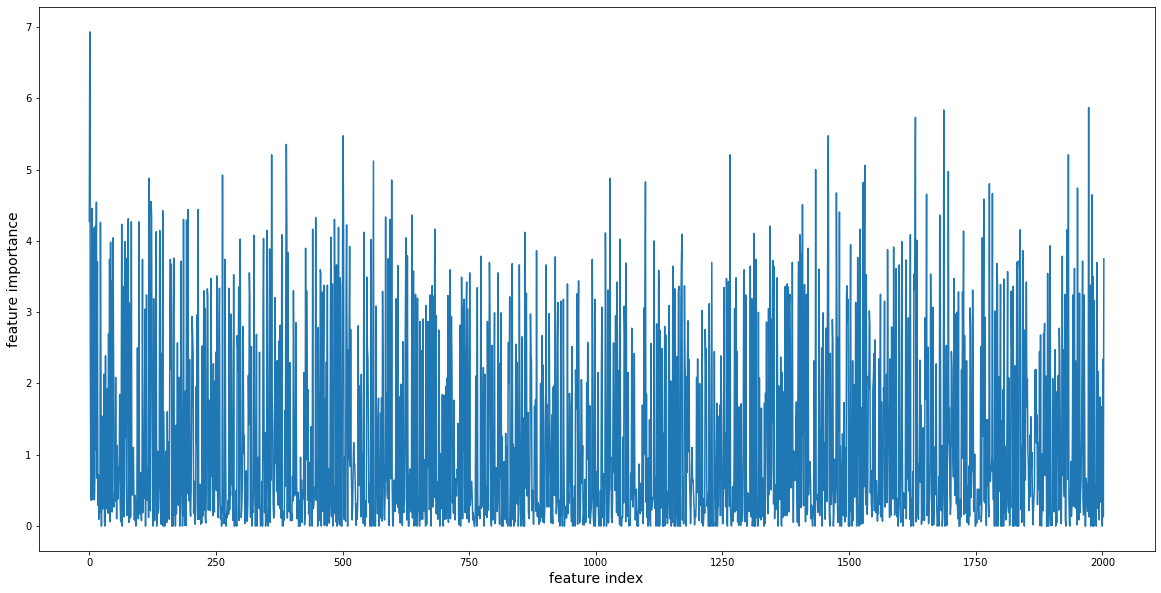

In [50]:
plt.figure(num=None, figsize=(20,10))
plt.plot(mordred_only_average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_mordred_only_bm_fis.png', dpi=100)

In [51]:
plt.close()

## Randomized Mordred vectors (random Mordred)
A random "barcode" is written for each unique molecule's Mordred vector drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [32]:
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,10,83.430800,4.591325,1,0,11.505249,5916.348144,0.0,4.431364e-01,-1.265689,...,3,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379
1,10,142.017485,4.187759,1,0,0.000000,7075.918101,0.0,1.419059e+00,-2.278748,...,2,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903
2,8,18.971829,4.388257,0,0,11.505249,4130.773394,0.0,1.901955e-01,-0.481514,...,1,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379
3,5,-58.349703,3.669951,0,0,4.603196,2222.145249,0.0,-1.332268e-15,0.363495,...,0,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379
4,4,-169.891933,3.621002,1,0,9.349867,1806.522986,0.0,0.000000e+00,0.935208,...,0,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,2,-96.192064,0.000000,0,0,0.000000,1491.142324,0.0,9.727653e-01,-0.388802,...,0,1.879398,0,0.156780,0.0,0,0,0.000000,0,0.000000
134632,11,31.813678,4.338923,1,0,19.944581,4631.144016,0.0,5.269603e-01,-1.769240,...,0,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903
134633,7,3.039573,3.766997,0,0,12.170333,3215.404570,0.0,3.377444e-01,-0.643624,...,0,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903
134635,11,50.778730,4.775967,1,0,21.880439,5293.709353,0.0,3.487811e-01,-1.016657,...,0,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379


In [33]:
# Get all unique Mordred vectors from dataset
# Separate molecules
X_full_mordred = pd.DataFrame(
    X_full[X_full.columns[300:]].copy().values, 
    index=X_full.index.values
)
reactant_1_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[:668]].copy().values, 
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[668:1336]].copy().values, 
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[1336:]].copy().values, 
    index=X_full.index.values
)

# Join tabulated vectors to single lists
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred],
    ignore_index=True
)
print(f'Total Mordred vectors: {len(unique_mordred)}')
unique_mordred = unique_mordred.drop_duplicates(subset=['str_joined'])
print(f'Unique Mordred vectors: {len(unique_mordred)}')

# Create random fake vector representations for all unique molecules
mordred_max = X_full_mordred.max().max()
unique_mordred['random'] = [
    (np.random.rand(668)*mordred_max).tolist() 
    for _ in range(len(unique_mordred))
]
unique_mordred['str_random'] = unique_mordred['random'].astype('str')
unique_mordred

Total Mordred vectors: 388008
Unique Mordred vectors: 145644


,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,random,str_random
0,10.0,83.430800,4.591325,1.0,0.0,11.505249,5916.348144,0.0,4.431364e-01,-1.265689,...,0.0,0.0,0.0,5.559267,0.0,0.000000,"[10.0, 83.43079953306149, 4.591324779166039, 1...","[10.0, 83.43079953306149, 4.591324779166039, 1...","[21968665841.101936, 6405614690.389585, 886987...","[21968665841.101936, 6405614690.389585, 886987..."
1,10.0,142.017485,4.187759,1.0,0.0,0.000000,7075.918101,0.0,1.419059e+00,-2.278748,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[10.0, 142.01748537155257, 4.187759006861526, ...","[10.0, 142.01748537155257, 4.187759006861526, ...","[45657516123.13882, 59517883606.259346, 940886...","[45657516123.13882, 59517883606.259346, 940886..."
2,8.0,18.971829,4.388257,0.0,0.0,11.505249,4130.773394,0.0,1.901955e-01,-0.481514,...,0.0,0.0,0.0,5.559267,0.0,0.000000,"[8.0, 18.971829369599813, 4.388257184424519, 0...","[8.0, 18.971829369599813, 4.388257184424519, 0...","[50292897486.5033, 27929796664.939854, 6603645...","[50292897486.5033, 27929796664.939854, 6603645..."
3,5.0,-58.349703,3.669951,0.0,0.0,4.603196,2222.145249,0.0,-1.332268e-15,0.363495,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[5.0, -58.349703428571395, 3.669951444228417, ...","[5.0, -58.349703428571395, 3.669951444228417, ...","[69557706965.23062, 47217800797.95583, 5955996...","[69557706965.23062, 47217800797.95583, 5955996..."
4,4.0,-169.891933,3.621002,1.0,0.0,9.349867,1806.522986,0.0,0.000000e+00,0.935208,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -169.8919334166667, 3.62100203171085, 1....","[4.0, -169.8919334166667, 3.62100203171085, 1....","[32278025159.400047, 94798564208.02321, 898254...","[32278025159.400047, 94798564208.02321, 898254..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388002,11.0,101.534135,4.338923,1.0,0.0,19.944581,5173.125457,0.0,6.293476e-01,-2.039969,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[11.0, 101.5341354016647, 4.3389233942563745, ...","[11.0, 101.5341354016647, 4.3389233942563745, ...","[76783131560.45734, 49678384803.209, 649962019...","[76783131560.45734, 49678384803.209, 649962019..."
388004,11.0,32.279882,4.400603,0.0,0.0,17.323443,4643.962926,0.0,3.018927e-01,-0.714374,...,0.0,0.0,0.0,0.000000,0.0,11.126903,"[11.0, 32.279882040428184, 4.400603020246816, ...","[11.0, 32.279882040428184, 4.400603020246816, ...","[14392374045.116373, 77595400096.90752, 284724...","[14392374045.116373, 77595400096.90752, 284724..."
388005,11.0,17.199528,4.471639,0.0,0.0,28.450346,4627.204702,0.0,2.329272e-01,-0.655101,...,0.0,0.0,0.0,0.000000,0.0,11.126903,"[11.0, 17.199528104637462, 4.471638793363568, ...","[11.0, 17.199528104637462, 4.471638793363568, ...","[54081937755.806786, 88510348371.83815, 509010...","[54081937755.806786, 88510348371.83815, 509010..."
388006,16.0,104.161281,5.111234,1.0,0.0,27.984709,7208.129305,0.0,2.557728e-01,-0.383820,...,0.0,0.0,0.0,5.687386,0.0,11.257379,"[16.0, 104.16128128000021, 5.111234492652372, ...","[16.0, 104.16128128000021, 5.111234492652372, ...","[64362991581.37436, 91354181706.26616, 2766098...","[64362991581.37436, 91354181706.26616, 2766098..."


In [34]:
# Create mapping from true vectors to random vectors
mordred_random_dict = dict(zip(unique_mordred['str_joined'], unique_mordred['str_random']))
len(mordred_random_dict)

145644

In [35]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['str_random'] = df['str_joined'].map(mordred_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,10.0,83.430800,4.591325,1.0,0.0,11.505249,5916.348144,0.0,4.431364e-01,-1.265689,...,0.0,0.0,0.0,5.559267,0.0,0.000000,"[10.0, 83.43079953306149, 4.591324779166039, 1...","[10.0, 83.43079953306149, 4.591324779166039, 1...","[21968665841.101936, 6405614690.389585, 886987...","[21968665841.101936, 6405614690.389585, 886987..."
1,10.0,142.017485,4.187759,1.0,0.0,0.000000,7075.918101,0.0,1.419059e+00,-2.278748,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[10.0, 142.01748537155257, 4.187759006861526, ...","[10.0, 142.01748537155257, 4.187759006861526, ...","[45657516123.13882, 59517883606.259346, 940886...","[45657516123.13882, 59517883606.259346, 940886..."
2,8.0,18.971829,4.388257,0.0,0.0,11.505249,4130.773394,0.0,1.901955e-01,-0.481514,...,0.0,0.0,0.0,5.559267,0.0,0.000000,"[8.0, 18.971829369599813, 4.388257184424519, 0...","[8.0, 18.971829369599813, 4.388257184424519, 0...","[50292897486.5033, 27929796664.939854, 6603645...","[50292897486.5033, 27929796664.939854, 6603645..."
3,5.0,-58.349703,3.669951,0.0,0.0,4.603196,2222.145249,0.0,-1.332268e-15,0.363495,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[5.0, -58.349703428571395, 3.669951444228417, ...","[5.0, -58.349703428571395, 3.669951444228417, ...","[69557706965.23062, 47217800797.95583, 5955996...","[69557706965.23062, 47217800797.95583, 5955996..."
4,4.0,-169.891933,3.621002,1.0,0.0,9.349867,1806.522986,0.0,0.000000e+00,0.935208,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -169.8919334166667, 3.62100203171085, 1....","[4.0, -169.8919334166667, 3.62100203171085, 1....","[32278025159.400047, 94798564208.02321, 898254...","[32278025159.400047, 94798564208.02321, 898254..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,11.0,31.813678,4.338923,1.0,0.0,19.944581,4631.144016,0.0,5.269603e-01,-1.769240,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[11.0, 31.81367801147988, 4.3389233942563745, ...","[11.0, 31.81367801147988, 4.3389233942563745, ...","[86638651766.2068, 22987165270.156425, 5237321...","[86638651766.2068, 22987165270.156425, 5237321..."
134633,7.0,3.039573,3.766997,0.0,0.0,12.170333,3215.404570,0.0,3.377444e-01,-0.643624,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[7.0, 3.0395727999999935, 3.766997233377889, 0...","[7.0, 3.0395727999999935, 3.766997233377889, 0...","[66392810216.97325, 23140922823.79241, 8259155...","[66392810216.97325, 23140922823.79241, 8259155..."
134634,7.0,3.039573,3.766997,0.0,0.0,12.170333,3215.404570,0.0,3.377444e-01,-0.643624,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[7.0, 3.0395727999999935, 3.766997233377889, 0...","[7.0, 3.0395727999999935, 3.766997233377889, 0...","[66392810216.97325, 23140922823.79241, 8259155...","[66392810216.97325, 23140922823.79241, 8259155..."
134635,11.0,50.778730,4.775967,1.0,0.0,21.880439,5293.709353,0.0,3.487811e-01,-1.016657,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[11.0, 50.77872955555562, 4.775967256930092, 1...","[11.0, 50.77872955555562, 4.775967256930092, 1...","[7107405624.021863, 55068705334.44093, 9463564...","[7107405624.021863, 55068705334.44093, 9463564..."


In [36]:
reactant_2_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,14.0,156.979438,4.934474,0.0,0.0,23.359046,10817.529466,0.0,1.063943,-2.637193,...,0.0,0.0,0.0,5.907180,0.0,0.0,"[14.0, 156.9794384905326, 4.934473933130692, 0...","[14.0, 156.9794384905326, 4.934473933130692, 0...","[78451951851.82777, 58934335163.43108, 6580736...","[78451951851.82777, 58934335163.43108, 6580736..."
1,20.0,98.303912,4.997212,0.0,0.0,56.025353,15128.041222,0.0,1.128230,-1.480322,...,0.0,0.0,0.0,0.000000,0.0,0.0,"[20.0, 98.30391234030407, 4.997212273764115, 0...","[20.0, 98.30391234030407, 4.997212273764115, 0...","[57161468159.56875, 2374218755.4438195, 672128...","[57161468159.56875, 2374218755.4438195, 672128..."
2,13.0,141.868311,4.941642,0.0,0.0,23.359046,10918.001411,0.0,1.368510,-2.007946,...,0.0,0.0,0.0,5.907180,0.0,0.0,"[13.0, 141.8683109573961, 4.941642422609304, 0...","[13.0, 141.8683109573961, 4.941642422609304, 0...","[32582786506.813416, 76047516875.8633, 5927346...","[32582786506.813416, 76047516875.8633, 5927346..."
3,9.0,40.782300,3.876396,0.0,0.0,13.213764,4726.898713,0.0,1.017578,-1.546956,...,0.0,0.0,0.0,0.000000,0.0,0.0,"[9.0, 40.78229960368997, 3.876395827784995, 0....","[9.0, 40.78229960368997, 3.876395827784995, 0....","[74181588326.66602, 48655348223.64136, 5298483...","[74181588326.66602, 48655348223.64136, 5298483..."
4,5.0,-70.275280,3.590439,0.0,0.0,5.462803,2991.579068,0.0,0.460784,-0.132320,...,0.0,0.0,0.0,0.000000,0.0,0.0,"[5.0, -70.27528042105277, 3.5904393813006834, ...","[5.0, -70.27528042105277, 3.5904393813006834, ...","[54826073100.01601, 16383410266.891005, 390123...","[54826073100.01601, 16383410266.891005, 390123..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,5.0,-72.867154,3.457893,0.0,0.0,5.462803,2494.949408,0.0,0.547180,-0.164388,...,0.0,0.0,0.0,0.000000,0.0,0.0,"[5.0, -72.86715374999999, 3.457892725338701, 0...","[5.0, -72.86715374999999, 3.457892725338701, 0...","[2925522119.806071, 68162521943.68857, 9379800...","[2925522119.806071, 68162521943.68857, 9379800..."
134633,6.0,-85.830181,3.590439,0.0,0.0,10.615913,2377.719239,0.0,0.266667,-0.468916,...,0.0,0.0,0.0,0.000000,0.0,0.0,"[6.0, -85.83018066666679, 3.5904393813006834, ...","[6.0, -85.83018066666679, 3.5904393813006834, ...","[26208932461.022465, 77388315025.48572, 428369...","[26208932461.022465, 77388315025.48572, 428369..."
134634,6.0,-103.211910,3.743604,0.0,0.0,0.000000,2360.961015,0.0,0.266667,-0.510681,...,0.0,0.0,0.0,0.000000,0.0,0.0,"[6.0, -103.21191000000002, 3.743604353803183, ...","[6.0, -103.21191000000002, 3.743604353803183, ...","[41528490833.6004, 59774021447.99257, 77917619...","[41528490833.6004, 59774021447.99257, 77917619..."
134635,9.0,73.112981,4.162782,0.0,0.0,0.000000,5502.117047,0.0,1.559399,-1.153814,...,0.0,0.0,0.0,5.687386,0.0,0.0,"[9.0, 73.11298145761225, 4.162781723775328, 0....","[9.0, 73.11298145761225, 4.162781723775328, 0....","[92184620300.25699, 10182259598.97741, 8222267...","[92184620300.25699, 10182259598.97741, 8222267..."


In [37]:
product_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,20.0,196.030236,5.378168,1.0,0.0,46.121674,12337.305211,0.0,0.440261,-1.262516,...,0.0,0.0,0.0,11.466447,0.0,11.257379,"[20.0, 196.03023599999926, 5.3781677480357715,...","[20.0, 196.03023599999926, 5.3781677480357715,...","[8066050959.321476, 93866413949.64818, 3762814...","[8066050959.321476, 93866413949.64818, 3762814..."
1,21.0,156.211836,5.183888,1.0,0.0,62.679536,16346.091502,0.0,1.045097,-1.260083,...,0.0,0.0,0.0,0.000000,0.0,11.126903,"[21.0, 156.21183634312285, 5.183888075797, 1.0...","[21.0, 156.21183634312285, 5.183888075797, 1.0...","[91534259751.5488, 29339236443.04669, 25586654...","[91534259751.5488, 29339236443.04669, 25586654..."
2,17.0,109.065321,5.295814,0.0,0.0,46.121674,10652.202407,0.0,0.697562,0.022238,...,0.0,0.0,0.0,11.466447,0.0,11.257379,"[17.0, 109.06532077777823, 5.295814236329918, ...","[17.0, 109.06532077777823, 5.295814236329918, ...","[25864127618.831406, 12955186180.724094, 16542...","[25864127618.831406, 12955186180.724094, 16542..."
3,9.0,-17.393523,4.350278,0.0,0.0,11.257379,3886.570084,0.0,0.000000,0.412454,...,0.0,0.0,0.0,0.000000,0.0,11.257379,"[9.0, -17.393522936848207, 4.350277936359301, ...","[9.0, -17.393522936848207, 4.350277936359301, ...","[46917472081.148125, 49856175754.7427, 2270732...","[46917472081.148125, 49856175754.7427, 2270732..."
4,7.0,45.725915,4.325787,1.0,0.0,5.563451,3848.941172,0.0,0.190196,1.201056,...,0.0,0.0,0.0,0.000000,0.0,10.440599,"[7.0, 45.72591544000011, 4.3257869163510065, 1...","[7.0, 45.72591544000011, 4.3257869163510065, 1...","[1754882876.117703, 72197611443.60211, 1638822...","[1754882876.117703, 72197611443.60211, 1638822..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,14.0,114.191152,4.703884,1.0,0.0,19.944581,6176.932542,0.0,0.513415,-1.584488,...,0.0,0.0,0.0,0.000000,0.0,11.126903,"[14.0, 114.19115159141329, 4.703883658924124, ...","[14.0, 114.19115159141329, 4.703883658924124, ...","[39452540007.31312, 22583668465.705097, 904424...","[39452540007.31312, 22583668465.705097, 904424..."
134633,11.0,32.279882,4.400603,0.0,0.0,17.323443,4643.962926,0.0,0.301893,-0.714374,...,0.0,0.0,0.0,0.000000,0.0,11.126903,"[11.0, 32.279882040428184, 4.400603020246816, ...","[11.0, 32.279882040428184, 4.400603020246816, ...","[14392374045.116373, 77595400096.90752, 284724...","[14392374045.116373, 77595400096.90752, 284724..."
134634,11.0,17.199528,4.471639,0.0,0.0,28.450346,4627.204702,0.0,0.232927,-0.655101,...,0.0,0.0,0.0,0.000000,0.0,11.126903,"[11.0, 17.199528104637462, 4.471638793363568, ...","[11.0, 17.199528104637462, 4.471638793363568, ...","[54081937755.806786, 88510348371.83815, 509010...","[54081937755.806786, 88510348371.83815, 509010..."
134635,16.0,104.161281,5.111234,1.0,0.0,27.984709,7208.129305,0.0,0.255773,-0.383820,...,0.0,0.0,0.0,5.687386,0.0,11.257379,"[16.0, 104.16128128000021, 5.111234492652372, ...","[16.0, 104.16128128000021, 5.111234492652372, ...","[64362991581.37436, 91354181706.26616, 2766098...","[64362991581.37436, 91354181706.26616, 2766098..."


In [38]:
reactant_1_mordred = pd.DataFrame(
    list(reactant_1_mordred['random'].values), 
    columns=X_full.columns[300:968],
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    list(reactant_2_mordred['random'].values), 
    columns=X_full.columns[968:1636],
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    list(product_mordred['random'].values), 
    columns=X_full.columns[1636:],
    index=X_full.index.values
)
reactant_1_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,rdfred_1_NsssN,rdfred_1_VSA_EState8,rdfred_1_n9FARing,rdfred_1_GGI6,rdfred_1_Xch-4d,rdfred_1_n7AHRing,rdfred_1_n10ARing,rdfred_1_PEOE_VSA13,rdfred_1_n7HRing,rdfred_1_SMR_VSA9
0,2.196867e+10,6.405615e+09,8.869876e+10,7.326960e+10,1.938447e+10,1.668826e+10,1.362125e+09,5.042027e+10,1.921559e+10,9.449991e+10,...,4.655524e+09,8.855897e+10,1.187801e+10,1.210511e+10,8.814732e+10,3.530570e+09,6.176187e+10,1.915419e+10,6.464200e+10,6.863978e+09
1,4.565752e+10,5.951788e+10,9.408865e+10,3.817067e+10,8.547680e+10,4.713463e+10,3.565207e+10,4.694402e+10,4.406178e+10,2.183115e+10,...,1.885879e+10,7.563651e+10,7.210296e+10,7.523554e+10,6.685624e+10,4.521921e+09,5.275660e+10,4.306317e+10,7.772534e+10,2.898759e+10
2,5.029290e+10,2.792980e+10,6.603646e+10,1.535854e+10,6.920060e+10,9.439629e+10,3.647041e+10,6.293522e+10,2.277824e+10,8.945665e+10,...,2.634272e+10,9.303191e+10,4.138785e+10,1.907365e+10,4.020292e+10,5.300510e+10,7.403939e+10,6.244740e+10,8.489268e+10,4.069948e+10
3,6.955771e+10,4.721780e+10,5.955996e+10,4.367109e+10,9.588921e+10,6.617542e+10,1.220334e+10,3.077494e+10,4.422125e+10,3.147855e+10,...,5.252078e+10,7.919266e+10,4.547110e+08,9.345035e+10,3.617570e+10,8.876287e+10,9.365316e+10,2.886937e+10,9.093573e+10,4.005831e+10
4,3.227803e+10,9.479856e+10,8.982542e+10,5.670983e+10,6.935888e+10,4.532809e+10,2.789903e+10,1.700096e+10,8.559678e+10,4.655289e+09,...,8.238817e+10,2.636857e+10,7.866738e+10,4.905408e+10,6.927091e+10,5.553134e+10,3.738994e+10,5.839452e+10,2.959406e+10,1.586802e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,8.663865e+10,2.298717e+10,5.237321e+09,6.646722e+10,4.520431e+10,6.314013e+10,4.211183e+10,2.928427e+10,2.304439e+10,7.241166e+10,...,8.692969e+10,1.042146e+09,2.991398e+10,8.884326e+10,1.352751e+10,8.988724e+10,3.349835e+10,7.270474e+10,6.311290e+10,5.498830e+10
134633,6.639281e+10,2.314092e+10,8.259156e+09,3.679833e+10,2.392512e+10,7.917429e+10,3.564786e+10,1.319295e+10,7.586816e+10,5.247173e+10,...,4.827327e+10,3.578188e+10,8.797216e+10,1.255144e+10,9.063800e+10,8.806910e+10,8.036394e+10,9.592746e+10,9.596984e+10,6.978062e+10
134634,6.639281e+10,2.314092e+10,8.259156e+09,3.679833e+10,2.392512e+10,7.917429e+10,3.564786e+10,1.319295e+10,7.586816e+10,5.247173e+10,...,4.827327e+10,3.578188e+10,8.797216e+10,1.255144e+10,9.063800e+10,8.806910e+10,8.036394e+10,9.592746e+10,9.596984e+10,6.978062e+10
134635,7.107406e+09,5.506871e+10,9.463564e+10,9.473744e+10,5.158986e+10,9.077205e+10,6.475785e+10,8.168050e+10,2.487993e+10,2.294207e+10,...,3.171973e+10,7.345923e+10,2.657536e+09,8.022518e+10,7.695529e+10,4.930426e+09,7.987731e+10,9.302943e+10,8.531398e+10,6.983476e+09


In [39]:
reactant_2_mordred

,rdfred_2_Diameter,rdfred_2_ATSC1m,rdfred_2_piPC3,rdfred_2_n5aHRing,rdfred_2_n4AHRing,rdfred_2_EState_VSA3,rdfred_2_ATS0i,rdfred_2_SaaSe,rdfred_2_CIC3,rdfred_2_ATSC1p,...,rdfred_2_NsssN,rdfred_2_VSA_EState8,rdfred_2_n9FARing,rdfred_2_GGI6,rdfred_2_Xch-4d,rdfred_2_n7AHRing,rdfred_2_n10ARing,rdfred_2_PEOE_VSA13,rdfred_2_n7HRing,rdfred_2_SMR_VSA9
0,7.845195e+10,5.893434e+10,6.580736e+10,2.817061e+10,5.623666e+10,9.343000e+10,6.264484e+10,6.451909e+10,9.270899e+10,3.103771e+10,...,7.649549e+10,9.004782e+10,6.153071e+10,2.514885e+10,5.065454e+10,5.290829e+10,2.232175e+10,5.934017e+10,4.888657e+10,4.712068e+10
1,5.716147e+10,2.374219e+09,6.721281e+10,8.102127e+10,8.613687e+10,9.291377e+10,2.372494e+10,4.849836e+09,1.696605e+10,7.459749e+10,...,2.700438e+10,5.288947e+10,5.693723e+09,9.503389e+10,2.123829e+10,6.346001e+10,1.851946e+10,2.978916e+10,8.510500e+10,4.916304e+10
2,3.258279e+10,7.604752e+10,5.927347e+10,6.920349e+09,5.105207e+10,7.801571e+09,1.823529e+10,9.360718e+10,5.236082e+10,9.606113e+10,...,8.606387e+10,2.405392e+10,1.698151e+10,7.036677e+10,1.082942e+10,1.777070e+10,5.808622e+10,2.728566e+10,3.021470e+10,4.761066e+10
3,7.418159e+10,4.865535e+10,5.298483e+10,2.071807e+10,1.554182e+10,4.230766e+10,2.572435e+10,4.635507e+10,7.042778e+10,3.320812e+10,...,1.427304e+10,3.753698e+10,9.485409e+10,6.220639e+10,2.516994e+10,2.356859e+10,4.245068e+10,5.475858e+10,6.059605e+10,1.827362e+10
4,5.482607e+10,1.638341e+10,3.901238e+10,8.105734e+10,3.179858e+10,1.312452e+10,8.137146e+10,9.578654e+10,2.726725e+10,1.348213e+10,...,6.274619e+10,3.858185e+10,5.902958e+09,3.459027e+10,7.722840e+09,1.152987e+10,9.546476e+09,5.716935e+10,6.807682e+10,2.768131e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,2.925522e+09,6.816252e+10,9.379800e+10,3.968049e+10,9.255687e+10,5.060315e+10,5.729671e+09,2.372024e+10,1.239543e+10,4.304930e+10,...,7.003875e+10,4.052882e+10,6.057273e+10,8.077739e+10,3.871790e+10,2.906690e+10,9.042072e+10,4.666625e+10,8.341854e+10,8.060359e+10
134633,2.620893e+10,7.738832e+10,4.283699e+10,4.496422e+10,5.088949e+10,5.890641e+10,2.186997e+09,7.439942e+10,5.650357e+10,5.971090e+10,...,3.593891e+10,3.309923e+10,8.711824e+10,4.524808e+10,6.735844e+10,8.153864e+10,9.443913e+10,1.766032e+10,3.647423e+10,9.594324e+10
134634,4.152849e+10,5.977402e+10,7.791762e+10,5.630902e+09,8.598978e+10,1.901426e+10,8.914883e+10,5.379107e+10,3.031561e+10,3.849735e+10,...,5.631048e+10,7.094754e+10,7.749779e+10,8.953547e+10,1.288974e+10,3.755625e+10,2.818802e+10,9.501217e+10,5.463906e+09,4.806814e+10
134635,9.218462e+10,1.018226e+10,8.222268e+10,4.080820e+10,1.283752e+10,4.425145e+10,1.393439e+09,4.125404e+10,2.972009e+10,8.327589e+10,...,1.042393e+10,8.008982e+10,7.070240e+10,6.461750e+10,9.572341e+09,4.474978e+10,1.786950e+10,2.486313e+10,8.018694e+10,5.985214e+10


In [40]:
product_mordred

,product_Diameter,product_ATSC1m,product_piPC3,product_n5aHRing,product_n4AHRing,product_EState_VSA3,product_ATS0i,product_SaaSe,product_CIC3,product_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,8.066051e+09,9.386641e+10,3.762815e+10,6.195290e+10,7.213449e+10,4.474493e+10,8.990648e+10,5.074575e+08,1.626582e+10,4.261063e+10,...,5.080629e+10,3.145491e+10,2.554056e+09,3.849439e+10,2.145370e+10,5.317177e+10,5.781806e+10,4.940370e+10,4.160616e+10,1.819998e+10
1,9.153426e+10,2.933924e+10,2.558665e+10,1.340908e+10,7.632128e+10,6.149146e+10,9.143481e+10,9.237405e+10,7.914712e+10,7.921929e+10,...,6.777353e+10,4.870328e+10,7.486053e+09,1.936695e+10,3.685019e+10,5.714998e+10,6.300131e+10,1.616321e+10,6.139163e+10,3.265799e+10
2,2.586413e+10,1.295519e+10,1.654257e+10,2.366793e+10,5.121989e+09,2.203907e+10,1.885855e+10,4.575274e+10,2.099098e+10,5.860094e+10,...,9.023437e+10,2.550510e+10,5.294985e+10,3.453610e+10,2.646201e+09,4.808108e+10,6.434101e+10,2.631256e+10,4.389925e+10,8.125941e+10
3,4.691747e+10,4.985618e+10,2.270733e+10,9.001158e+10,6.987137e+10,8.350997e+10,6.409258e+10,3.854957e+10,7.305072e+10,9.280731e+10,...,4.574313e+10,8.786967e+10,1.442104e+10,1.119288e+09,4.403084e+10,6.421708e+10,6.572996e+10,6.714904e+10,5.746791e+10,7.950726e+10
4,1.754883e+09,7.219761e+10,1.638822e+10,3.994715e+10,3.612503e+09,4.801816e+10,8.182345e+10,6.505930e+10,7.388933e+10,1.908694e+10,...,3.198902e+10,6.008018e+10,8.715956e+10,9.444766e+10,8.112790e+09,5.149936e+09,7.916261e+10,6.775656e+10,3.938331e+10,4.797440e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,3.945254e+10,2.258367e+10,9.044249e+10,1.415159e+10,3.673408e+10,3.558090e+10,7.022546e+10,1.742417e+10,2.714368e+10,4.980226e+10,...,3.281488e+10,1.348807e+10,3.385876e+10,3.547967e+10,2.057452e+09,2.829037e+10,6.503726e+10,5.145290e+10,1.199171e+10,9.510853e+10
134633,1.439237e+10,7.759540e+10,2.847244e+10,2.938939e+10,4.465899e+10,8.896582e+10,2.815532e+10,9.430647e+10,6.200134e+10,8.135903e+09,...,7.871161e+10,2.334886e+10,3.656899e+10,4.742807e+10,5.271948e+10,6.572171e+10,6.318786e+10,1.676327e+10,7.702186e+10,2.470339e+10
134634,5.408194e+10,8.851035e+10,5.090103e+10,7.782301e+10,7.299265e+10,1.241323e+10,6.174260e+10,6.173742e+10,4.810977e+10,6.355291e+10,...,3.664312e+09,7.471015e+10,2.294526e+09,4.004577e+09,7.814820e+10,7.758848e+10,5.032174e+09,1.270665e+10,7.715430e+10,7.766120e+08
134635,6.436299e+10,9.135418e+10,2.766099e+10,9.042972e+10,3.421564e+10,9.251969e+10,3.890587e+10,8.071287e+10,4.990262e+10,2.699861e+10,...,1.638443e+10,2.178268e+10,3.847355e+08,2.849655e+10,4.017432e+10,6.772914e+09,6.506965e+10,9.550305e+10,7.194931e+10,3.016546e+10


In [41]:
# Re-combine component molecules into full dataframe
X_full_random_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred], axis=1
)

# View new dataframe
X_full_random_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,2.196867e+10,6.405615e+09,8.869876e+10,7.326960e+10,1.938447e+10,1.668826e+10,1.362125e+09,5.042027e+10,1.921559e+10,9.449991e+10,...,5.080629e+10,3.145491e+10,2.554056e+09,3.849439e+10,2.145370e+10,5.317177e+10,5.781806e+10,4.940370e+10,4.160616e+10,1.819998e+10
1,4.565752e+10,5.951788e+10,9.408865e+10,3.817067e+10,8.547680e+10,4.713463e+10,3.565207e+10,4.694402e+10,4.406178e+10,2.183115e+10,...,6.777353e+10,4.870328e+10,7.486053e+09,1.936695e+10,3.685019e+10,5.714998e+10,6.300131e+10,1.616321e+10,6.139163e+10,3.265799e+10
2,5.029290e+10,2.792980e+10,6.603646e+10,1.535854e+10,6.920060e+10,9.439629e+10,3.647041e+10,6.293522e+10,2.277824e+10,8.945665e+10,...,9.023437e+10,2.550510e+10,5.294985e+10,3.453610e+10,2.646201e+09,4.808108e+10,6.434101e+10,2.631256e+10,4.389925e+10,8.125941e+10
3,6.955771e+10,4.721780e+10,5.955996e+10,4.367109e+10,9.588921e+10,6.617542e+10,1.220334e+10,3.077494e+10,4.422125e+10,3.147855e+10,...,4.574313e+10,8.786967e+10,1.442104e+10,1.119288e+09,4.403084e+10,6.421708e+10,6.572996e+10,6.714904e+10,5.746791e+10,7.950726e+10
4,3.227803e+10,9.479856e+10,8.982542e+10,5.670983e+10,6.935888e+10,4.532809e+10,2.789903e+10,1.700096e+10,8.559678e+10,4.655289e+09,...,3.198902e+10,6.008018e+10,8.715956e+10,9.444766e+10,8.112790e+09,5.149936e+09,7.916261e+10,6.775656e+10,3.938331e+10,4.797440e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,8.663865e+10,2.298717e+10,5.237321e+09,6.646722e+10,4.520431e+10,6.314013e+10,4.211183e+10,2.928427e+10,2.304439e+10,7.241166e+10,...,3.281488e+10,1.348807e+10,3.385876e+10,3.547967e+10,2.057452e+09,2.829037e+10,6.503726e+10,5.145290e+10,1.199171e+10,9.510853e+10
134633,6.639281e+10,2.314092e+10,8.259156e+09,3.679833e+10,2.392512e+10,7.917429e+10,3.564786e+10,1.319295e+10,7.586816e+10,5.247173e+10,...,7.871161e+10,2.334886e+10,3.656899e+10,4.742807e+10,5.271948e+10,6.572171e+10,6.318786e+10,1.676327e+10,7.702186e+10,2.470339e+10
134634,6.639281e+10,2.314092e+10,8.259156e+09,3.679833e+10,2.392512e+10,7.917429e+10,3.564786e+10,1.319295e+10,7.586816e+10,5.247173e+10,...,3.664312e+09,7.471015e+10,2.294526e+09,4.004577e+09,7.814820e+10,7.758848e+10,5.032174e+09,1.270665e+10,7.715430e+10,7.766120e+08
134635,7.107406e+09,5.506871e+10,9.463564e+10,9.473744e+10,5.158986e+10,9.077205e+10,6.475785e+10,8.168050e+10,2.487993e+10,2.294207e+10,...,1.638443e+10,2.178268e+10,3.847355e+08,2.849655e+10,4.017432e+10,6.772914e+09,6.506965e+10,9.550305e+10,7.194931e+10,3.016546e+10


In [42]:
# Re-split full dataset based on test indices
X_train_random_mordred = X_full_random_mordred[
    ~X_full_random_mordred.index.isin(test_inds)
]
X_test_random_mordred = X_full_random_mordred[
    X_full_random_mordred.index.isin(test_inds)
]

# Check sets
print(X_train_random_mordred.shape, y_train.shape, 
      X_test_random_mordred.shape, y_test.shape)

(116505, 2004) (116505, 118) (12831, 2004) (12831, 118)


In [43]:
# Re-train and test model
start_time = time.time()
random_mordred_file = 'random_mordred_bm_gbm.model.joblib'
random_mordred_bm_gbm = train_lgbm_classifier(
    X_train_random_mordred, y_train, random_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_mordred_preds = random_mordred_bm_gbm.predict_proba(
    X_test_random_mordred
)

# Get top-k predicted rankings from prediction set
random_mordred_preds_labeled = get_top_k_preds(
    random_mordred_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_mordred_formatted_results = format_results_for_metrics(
    random_mordred_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_mordred_metrics = get_metrics_dict(
    random_mordred_formatted_results, type_count, 'random_mordred_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_mordred_top_1_acc = random_mordred_metrics['top_1_acc']
random_mordred_top_3_acc = random_mordred_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 6097.150166988373 s
Top 1 accuracy for type  M  : 0.43542981840854184
Top 3 accuracy for type  M  : 0.767983789260385
Top 1 accuracy for type  L  : 0.8352427714129842
Top 3 accuracy for type  L  : 0.9461460525290313
Top 1 accuracy for type  B  : 0.414464967656457
Top 3 accuracy for type  B  : 0.7855973813420621
Top 1 accuracy for type  S  : 0.6511573532850129
Top 3 accuracy for type  S  : 0.8305665965240433
Top 1 accuracy for type  A  : 0.8904995713506352
Top 3 accuracy for type  A  : 0.9782557867664251


### Feature importances

In [44]:
num_estimators = len(random_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_mordred_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_random_mordred.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('suzuki_random_mordred_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_random_mordred.columns[top_fis]

print(top_fi_names)

Index(['rdfred_1_Diameter', 'rdfred_1_ATSC1m', 'rdfred_1_piPC3',
       'rdfred_1_EState_VSA3', 'rdfred_1_n4AHRing', 'rdfred_2_Diameter',
       'rdfred_1_CIC3', 'rdfred_1_PEOE_VSA3', 'rdfred_1_ATS4p',
       'rdfred_1_ATS0i', 'rdfred_1_n5aHRing', 'rdfred_1_SaaSe',
       'rdfred_2_PEOE_VSA11', 'rdfred_2_ATS2Z', 'rdfred_1_NaaO',
       'rdfred_1_NsssP', 'rdfred_1_n12ARing', 'rdfred_1_ATSC6d',
       'rdfred_1_nHBDon', 'rdfred_1_NssssSn'],
      dtype='object')


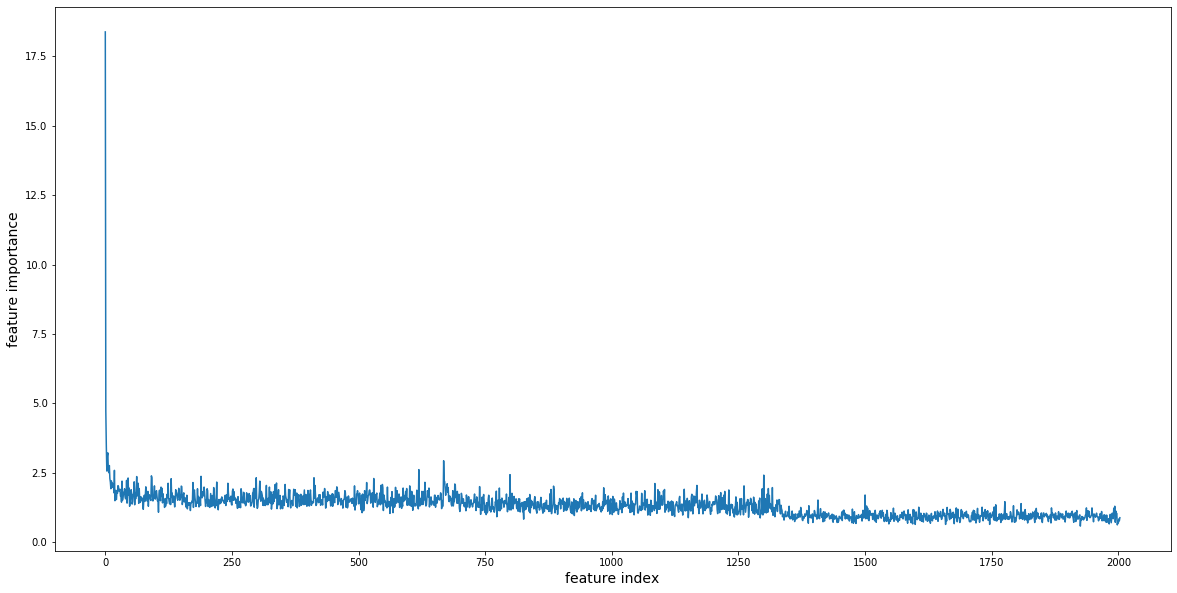

In [45]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_random_mordred_bm_fis.png', dpi=100)

In [46]:
plt.close()

### Shuffle Mordred vectors, leaving outputs the same (shuffle Mordred)
Trains model on fake reactions, testing on same test set of real ones

In [47]:
# Show Mordred dataset for comparison
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,10,83.430800,4.591325,1,0,11.505249,5916.348144,0.0,4.431364e-01,-1.265689,...,3,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379
1,10,142.017485,4.187759,1,0,0.000000,7075.918101,0.0,1.419059e+00,-2.278748,...,2,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903
2,8,18.971829,4.388257,0,0,11.505249,4130.773394,0.0,1.901955e-01,-0.481514,...,1,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379
3,5,-58.349703,3.669951,0,0,4.603196,2222.145249,0.0,-1.332268e-15,0.363495,...,0,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379
4,4,-169.891933,3.621002,1,0,9.349867,1806.522986,0.0,0.000000e+00,0.935208,...,0,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,2,-96.192064,0.000000,0,0,0.000000,1491.142324,0.0,9.727653e-01,-0.388802,...,0,1.879398,0,0.156780,0.0,0,0,0.000000,0,0.000000
134632,11,31.813678,4.338923,1,0,19.944581,4631.144016,0.0,5.269603e-01,-1.769240,...,0,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903
134633,7,3.039573,3.766997,0,0,12.170333,3215.404570,0.0,3.377444e-01,-0.643624,...,0,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903
134635,11,50.778730,4.775967,1,0,21.880439,5293.709353,0.0,3.487811e-01,-1.016657,...,0,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379


In [48]:
# Shuffle row ordering removing index
X_train_mordred_shuffle = np.random.permutation(X_train_mordred.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_mordred_shuffle_inputs = pd.DataFrame(
    X_train_mordred_shuffle, index=X_train_mordred.index, 
    columns=X_train_mordred.columns
)

# View new dataframe (can see inputs have changed)
X_train_mordred_shuffle_inputs

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,5.0,-3.552714e-14,3.409496,0.0,0.0,0.000000,2321.549927,0.0,3.169925e-01,3.164136e-15,...,0.0,0.000000,0.0,0.160000,0.0,0.0,0.0,0.000000,0.0,11.126903
1,11.0,2.987706e+02,4.980176,0.0,0.0,9.989420,6156.065762,0.0,2.951224e-01,-2.537899e+00,...,0.0,37.498460,0.0,1.187029,0.0,0.0,0.0,0.000000,0.0,17.203687
2,9.0,7.865758e+01,4.307438,0.0,0.0,11.436898,6125.541064,0.0,1.447883e+00,-1.752256e+00,...,0.0,43.209968,0.0,1.115918,0.0,0.0,0.0,11.829709,0.0,28.133794
3,5.0,-3.966545e+01,3.590439,0.0,0.0,0.000000,2717.707642,0.0,3.973463e-01,6.597826e-01,...,0.0,0.000000,0.0,0.202449,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4.0,-4.771482e+00,2.564949,0.0,0.0,0.000000,2807.567202,0.0,2.377444e+00,-4.751563e+00,...,0.0,1.795587,0.0,0.444898,0.0,0.0,0.0,5.559267,0.0,11.257379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,8.0,-9.358662e+01,4.340553,0.0,0.0,5.462803,3326.610355,0.0,1.818182e-01,-2.034661e-01,...,0.0,1.053436,0.0,0.423673,0.0,0.0,0.0,0.000000,0.0,11.126903
134632,15.0,3.287607e+02,5.577841,4.0,0.0,22.588709,13226.578831,0.0,2.371622e+00,2.837726e+00,...,0.0,41.182001,0.0,2.038685,0.0,0.0,0.0,0.000000,0.0,11.126903
134633,5.0,6.267155e+00,3.669951,0.0,0.0,0.000000,2222.145249,0.0,-1.332268e-15,5.873583e-01,...,0.0,0.000000,0.0,0.182041,0.0,0.0,0.0,5.687386,0.0,11.126903
134635,12.0,-5.001309e+00,4.741666,1.0,0.0,11.697866,4905.774895,0.0,2.178996e-01,-4.472149e-01,...,0.0,1.961116,0.0,0.489932,0.0,0.0,0.0,0.000000,0.0,17.006891


In [49]:
# But indices have stayed the same
X_train_mordred_shuffle_inputs.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            134625, 134626, 134627, 134628, 134630, 134631, 134632, 134633,
            134635, 134636],
           dtype='int64', length=116505)

In [50]:
X_train_mordred.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            134625, 134626, 134627, 134628, 134630, 134631, 134632, 134633,
            134635, 134636],
           dtype='int64', length=116505)

In [51]:
# Check test set
X_test_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
8,14,431.483908,5.031255,1,0,13.337699,11337.726730,0.0,1.386552,3.166400,...,1,1.799630,0,1.232063,0.0,0,0,0.000000,0,28.133794
28,11,-43.795516,4.617593,0,0,9.989420,5382.429656,0.0,0.386512,-0.254713,...,0,0.000000,0,0.667755,0.0,0,0,5.907180,0,16.876415
29,11,-43.795516,4.617593,0,0,9.989420,5382.429656,0.0,0.386512,-0.254713,...,0,0.000000,0,0.933878,0.0,0,0,11.594566,0,16.876415
65,11,138.934143,4.588787,1,0,5.131558,6570.371656,0.0,1.360352,-1.054445,...,0,3.246661,0,1.417370,0.0,0,0,5.559267,0,28.071669
100,10,30.447375,5.051457,1,0,22.290781,6047.668687,0.0,0.658409,-0.761355,...,0,24.748169,0,1.063810,0.0,0,0,0.000000,0,11.126903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134607,5,-103.950892,3.630985,0,0,0.000000,2680.400694,0.0,0.352941,0.307797,...,0,5.216139,0,0.180408,0.0,0,0,0.000000,0,0.000000
134614,6,-84.865886,3.590439,0,0,10.485437,2478.191184,0.0,0.250000,-0.257450,...,0,2.368521,0,1.383175,0.0,0,0,0.000000,0,16.876415
134615,6,-84.865886,3.590439,0,0,10.485437,2478.191184,0.0,0.250000,-0.257450,...,0,0.000000,0,2.791429,0.0,0,0,5.687386,0,11.126903
134629,7,-55.140086,3.669951,0,0,11.212315,3177.030354,0.0,0.437744,-0.559810,...,2,0.000000,0,1.569116,0.0,0,0,0.000000,0,16.876415


In [52]:
# Re-train and test model
start_time = time.time()
shuffle_mordred_file = 'shuffle_mordred_bm_gbm.model.joblib'
shuffle_mordred_bm_gbm = train_lgbm_classifier(
    X_train_mordred_shuffle_inputs, y_train, shuffle_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_mordred_bm_preds = shuffle_mordred_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
shuffle_mordred_bm_preds_labeled = get_top_k_preds(
    shuffle_mordred_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_mordred_bm_formatted_results = format_results_for_metrics(
    shuffle_mordred_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_mordred_bm_metrics = get_metrics_dict(
    shuffle_mordred_bm_formatted_results, type_count, 
    'shuffle_mordred_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_mordred_top_1_acc = shuffle_mordred_bm_metrics['top_1_acc']
shuffle_mordred_top_3_acc = shuffle_mordred_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 5030.233510017395 s
Top 1 accuracy for type  M  : 0.3784584210116125
Top 3 accuracy for type  M  : 0.6747720364741642
Top 1 accuracy for type  L  : 0.8724183617800639
Top 3 accuracy for type  L  : 0.9215961343620918
Top 1 accuracy for type  B  : 0.309328968903437
Top 3 accuracy for type  B  : 0.7276907489673448
Top 1 accuracy for type  S  : 0.6459356246590289
Top 3 accuracy for type  S  : 0.80079494973112
Top 1 accuracy for type  A  : 0.9202712181435586
Top 3 accuracy for type  A  : 0.9738134206219312


### Feature importances

In [53]:
num_estimators = len(shuffle_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_mordred_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_mordred_shuffle_inputs.columns[top_fis]

print(top_fi_names)

Index(['product_JGI7', 'product_JGI6', 'product_JGI10', 'product_JGI9',
       'product_JGI3', 'product_JGI8', 'product_EState_VSA7', 'product_JGI5',
       'product_ATSC8i', 'product_JGI4', 'product_ATSC4i', 'product_ATSC6i',
       'product_ATSC7i', 'product_ATSC8dv', 'product_ATSC8d',
       'product_PEOE_VSA7', 'product_ATSC3dv', 'product_CIC3',
       'product_ATSC2dv', 'product_ATSC8se'],
      dtype='object')


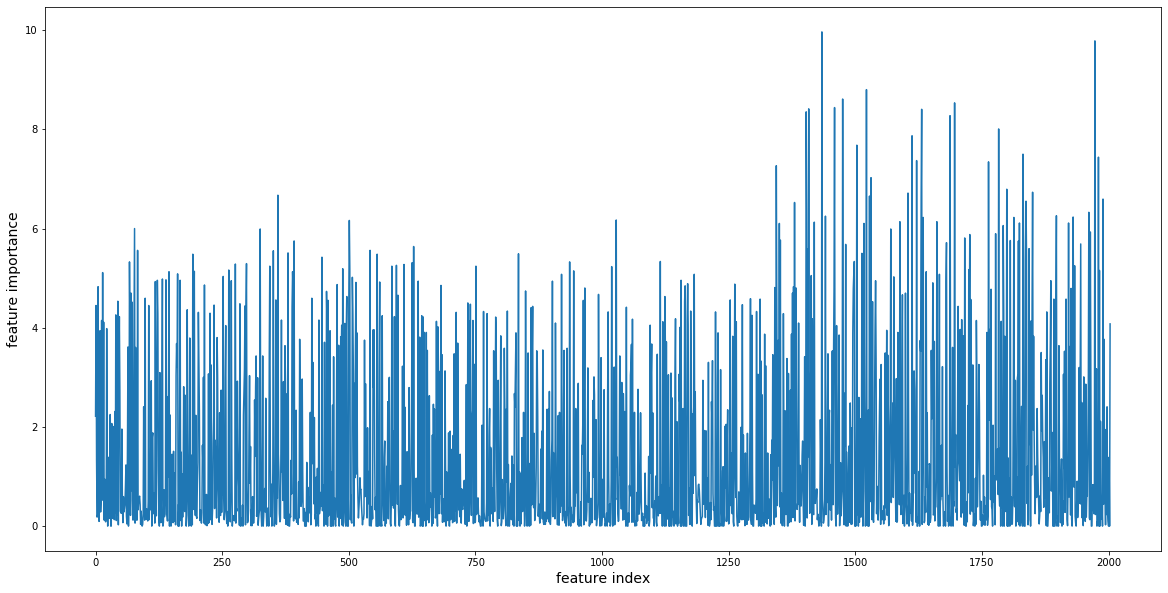

In [54]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_shuffle_mordred_bm_fis.png', dpi=100)

In [55]:
plt.close()

### Ablate Mordred region (SMILES only)

In [56]:
# Create new dataframe from only the Mordred input region
X_train_smiles = X_train[X_train.columns[:300]].copy()
X_test_smiles = X_test[X_test.columns[:300]].copy()
print(X_test_smiles.shape)

# View new dataframe (can see inputs have changed)
X_train_smiles

(12831, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,67.0,108.0,67.0,49.0,61.0,67.0,78.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Re-train and test model
start_time = time.time()
smiles_only_file = 'smiles_only_bm_gbm.model.joblib'
smiles_only_bm_gbm = train_lgbm_classifier(X_train_smiles, y_train, smiles_only_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
smiles_only_preds = smiles_only_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
smiles_only_preds_labeled = get_top_k_preds(
    smiles_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
smiles_only_formatted_results = format_results_for_metrics(
    smiles_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
smiles_only_metrics = get_metrics_dict(
    smiles_only_formatted_results, type_count, 'smiles_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
smiles_only_top_1_acc = smiles_only_metrics['top_1_acc']
smiles_only_top_3_acc = smiles_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 481.23006796836853 s
Top 1 accuracy for type  M  : 0.5459434182838439
Top 3 accuracy for type  M  : 0.8264359753721456
Top 1 accuracy for type  L  : 0.8555841321798768
Top 3 accuracy for type  L  : 0.9608760034291949
Top 1 accuracy for type  B  : 0.46488972020886915
Top 3 accuracy for type  B  : 0.8078092120645313
Top 1 accuracy for type  S  : 0.6723560127815447
Top 3 accuracy for type  S  : 0.8524666822539163
Top 1 accuracy for type  A  : 0.9160626607435118
Top 3 accuracy for type  A  : 0.9862832203257735


### Feature importances

In [58]:
num_estimators = len(smiles_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(smiles_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_smiles.columns[top_fis]

print(top_fi_names)

Index(['10', '201', '11', '13', '9', '6', '7', '16', '15', '14', '110', '12',
       '218', '8', '113', '116', '214', '111', '19', '5'],
      dtype='object')


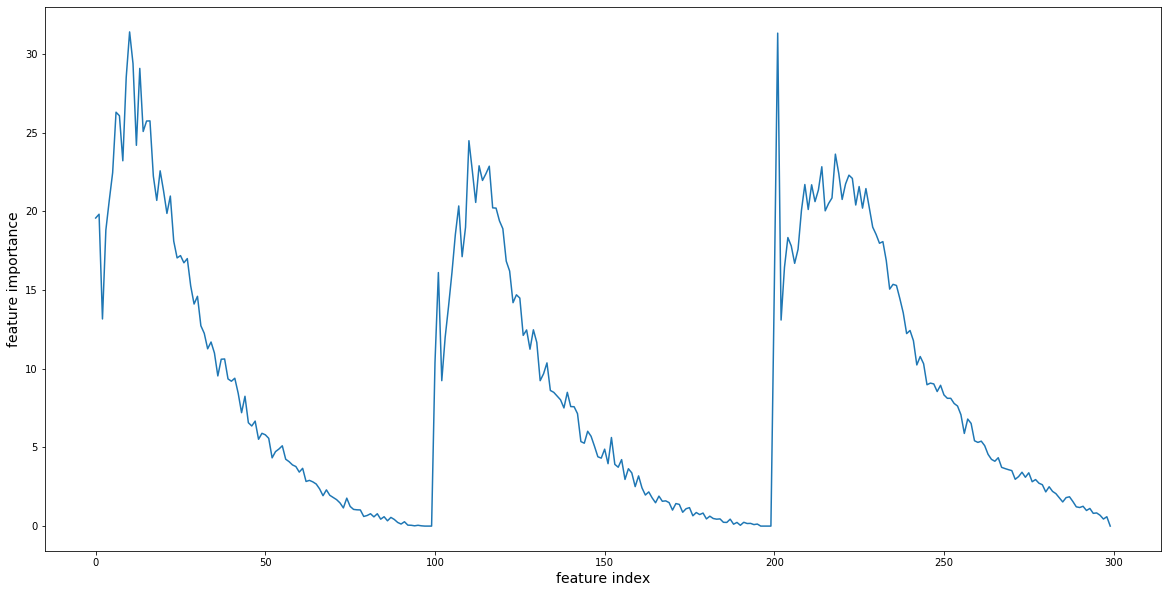

In [59]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_smiles_only_bm_fis.png', dpi=100)

In [60]:
plt.close()

### Randomized SMILES representations (random SMILES)
A random "barcode" is written for each unique molecule's SMILES drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [61]:
# Get all unique tokenized SMILES from dataset
# Separate molecules
reactant_1_smiles = pd.DataFrame(
    X_full[X_full.columns[:100]].copy().values, index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    X_full[X_full.columns[100:200]].copy().values, index=X_full.index.values
)
product_smiles = pd.DataFrame(
    X_full[X_full.columns[200:300]].copy().values, index=X_full.index.values
)

# Join tabulated SMILES to single lists
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], ignore_index=True
)
print(f'Total SMILES: {len(unique_smiles)}')
unique_smiles = unique_smiles.drop_duplicates(subset=['str_joined'])
print(f'Unique SMILES: {len(unique_smiles)}')

# Create random fake SMILES representations for all unique molecules
unique_smiles['random'] = [
    np.random.randint(115, size=100).tolist() 
    for _ in range(len(unique_smiles))
]
unique_smiles['str_random'] = unique_smiles['random'].astype('str')
unique_smiles

Total SMILES: 388008
Unique SMILES: 147470


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,random,str_random
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ...","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ..."
11,78.0,67.0,49.0,61.0,67.0,40.0,66.0,114.0,41.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 67.0, 49.0, 61.0, 67.0, 40.0, 66.0, 114...","[78.0, 67.0, 49.0, 61.0, 67.0, 40.0, 66.0, 114...","[56, 104, 27, 42, 89, 24, 105, 80, 22, 71, 110...","[56, 104, 27, 42, 89, 24, 105, 80, 22, 71, 110..."
12,67.0,78.0,49.0,78.0,61.0,78.0,78.0,40.0,67.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 78.0, 49.0, 78.0, 61.0, 78.0, 78.0, 40....","[67.0, 78.0, 49.0, 78.0, 61.0, 78.0, 78.0, 40....","[80, 26, 61, 40, 4, 86, 24, 63, 72, 10, 23, 16...","[80, 26, 61, 40, 4, 86, 24, 63, 72, 10, 23, 16..."
13,67.0,67.0,49.0,61.0,78.0,67.0,40.0,78.0,41.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 49.0, 61.0, 78.0, 67.0, 40.0, 78....","[67.0, 67.0, 49.0, 61.0, 78.0, 67.0, 40.0, 78....","[20, 46, 68, 8, 11, 97, 90, 71, 75, 55, 6, 112...","[20, 46, 68, 8, 11, 97, 90, 71, 75, 55, 6, 112..."
22,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[17, 81, 56, 46, 64, 34, 21, 109, 93, 51, 42, ...","[17, 81, 56, 46, 64, 34, 21, 109, 93, 51, 42, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387929,79.0,91.0,67.0,64.0,72.0,93.0,49.0,67.0,91.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 91.0, 67.0, 64.0, 72.0, 93.0, 49.0, 67....","[79.0, 91.0, 67.0, 64.0, 72.0, 93.0, 49.0, 67....","[37, 39, 15, 85, 60, 21, 83, 79, 35, 64, 18, 4...","[37, 39, 15, 85, 60, 21, 83, 79, 35, 64, 18, 4..."
387930,78.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40.0, 61....","[78.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40.0, 61....","[0, 55, 47, 108, 53, 45, 90, 14, 112, 83, 23, ...","[0, 55, 47, 108, 53, 45, 90, 14, 112, 83, 23, ..."
387931,78.0,67.0,49.0,61.0,78.0,67.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 67.0, 49.0, 61.0, 78.0, 67.0, 40.0, 61....","[78.0, 67.0, 49.0, 61.0, 78.0, 67.0, 40.0, 61....","[9, 103, 79, 60, 38, 19, 5, 95, 80, 11, 59, 52...","[9, 103, 79, 60, 38, 19, 5, 95, 80, 11, 59, 52..."
387932,78.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40.0, 61....","[78.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40.0, 61....","[105, 81, 42, 94, 82, 111, 0, 75, 33, 88, 112,...","[105, 81, 42, 94, 82, 111, 0, 75, 33, 88, 112,..."


In [62]:
# Create mapping from true SMILES to ranom SMILES
smiles_random_dict = dict(zip(unique_smiles['str_joined'], unique_smiles['str_random']))
len(smiles_random_dict)

147470

In [63]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['str_random'] = df['str_joined'].map(smiles_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ...","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ..."
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ...","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ..."
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ...","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ..."
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ...","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ..."
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[67.0, 79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67....","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ...","[25, 76, 83, 42, 87, 43, 88, 91, 60, 102, 31, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[76, 8, 49, 37, 110, 110, 20, 42, 81, 114, 0, ...","[76, 8, 49, 37, 110, 110, 20, 42, 81, 114, 0, ..."
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67.0, 49....","[67.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67.0, 49....","[44, 109, 77, 15, 54, 6, 92, 31, 21, 109, 106,...","[44, 109, 77, 15, 54, 6, 92, 31, 21, 109, 106,..."
134634,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[64, 19, 54, 100, 68, 71, 4, 96, 43, 59, 89, 4...","[64, 19, 54, 100, 68, 71, 4, 96, 43, 59, 89, 4..."
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[27, 9, 82, 91, 14, 85, 105, 95, 101, 39, 79, ...","[27, 9, 82, 91, 14, 85, 105, 95, 101, 39, 79, ..."


In [64]:
reactant_2_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,79.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[79.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[44, 42, 63, 80, 87, 81, 34, 46, 47, 71, 14, 6...","[44, 42, 63, 80, 87, 81, 34, 46, 47, 71, 14, 6..."
1,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[26, 32, 18, 80, 67, 59, 23, 12, 93, 40, 101, ...","[26, 32, 18, 80, 67, 59, 23, 12, 93, 40, 101, ..."
2,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[71, 7, 111, 18, 90, 33, 2, 104, 3, 12, 19, 10...","[71, 7, 111, 18, 90, 33, 2, 104, 3, 12, 19, 10..."
3,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[80, 9, 17, 67, 26, 9, 62, 62, 6, 98, 62, 31, ...","[80, 9, 17, 67, 26, 9, 62, 62, 6, 98, 62, 31, ..."
4,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[35, 20, 10, 89, 26, 14, 78, 6, 43, 96, 39, 40...","[35, 20, 10, 89, 26, 14, 78, 6, 43, 96, 39, 40..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ...","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ..."
134633,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ...","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ..."
134634,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ...","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ..."
134635,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[79.0, 66.0, 40.0, 79.0, 41.0, 67.0, 49.0, 61....","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ...","[110, 68, 27, 23, 34, 87, 20, 71, 18, 37, 26, ..."


In [65]:
product_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,79.0,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[79.0, 67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[111, 17, 56, 97, 31, 4, 58, 3, 61, 113, 62, 4...","[111, 17, 56, 97, 31, 4, 58, 3, 61, 113, 62, 4..."
1,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67.0, 49....","[79.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67.0, 49....","[31, 85, 60, 100, 60, 40, 17, 24, 28, 22, 103,...","[31, 85, 60, 100, 60, 40, 17, 24, 28, 22, 103,..."
2,67.0,79.0,67.0,49.0,61.0,67.0,40.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 40.0, 67....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 40.0, 67....","[70, 38, 0, 74, 32, 27, 94, 51, 13, 43, 76, 34...","[70, 38, 0, 74, 32, 27, 94, 51, 13, 43, 76, 34..."
3,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[49, 70, 78, 45, 56, 109, 66, 47, 95, 46, 79, ...","[49, 70, 78, 45, 56, 109, 66, 47, 95, 46, 79, ..."
4,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[47, 28, 10, 22, 110, 52, 97, 103, 66, 105, 37...","[47, 28, 10, 22, 110, 52, 97, 103, 66, 105, 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[67.0, 79.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61....","[5, 47, 103, 97, 35, 42, 17, 12, 42, 14, 30, 9...","[5, 47, 103, 97, 35, 42, 17, 12, 42, 14, 30, 9..."
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67.0, 49....","[67.0, 67.0, 40.0, 61.0, 79.0, 41.0, 67.0, 49....","[26, 77, 51, 32, 51, 3, 66, 64, 90, 7, 18, 59,...","[26, 77, 51, 32, 51, 3, 66, 64, 90, 7, 18, 59,..."
134634,67.0,67.0,49.0,61.0,67.0,40.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 49.0, 61.0, 67.0, 40.0, 67.0, 61....","[67.0, 67.0, 49.0, 61.0, 67.0, 40.0, 67.0, 61....","[71, 47, 14, 57, 23, 93, 23, 102, 54, 21, 3, 1...","[71, 47, 14, 57, 23, 93, 23, 102, 54, 21, 3, 1..."
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[67.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61.0, 67....","[109, 80, 25, 62, 32, 46, 22, 30, 59, 27, 56, ...","[109, 80, 25, 62, 32, 46, 22, 30, 59, 27, 56, ..."


In [66]:
reactant_1_smiles = pd.DataFrame(
    list(reactant_1_smiles['random'].values), columns=list(np.arange(0, 100)),
    index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    list(reactant_2_smiles['random'].values), columns=list(np.arange(100, 200)),
    index=X_full.index.values
)
product_smiles = pd.DataFrame(
    list(product_smiles['random'].values), columns=list(np.arange(200, 300)),
    index=X_full.index.values
)
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,25,76,83,42,87,43,88,91,60,102,...,73,14,21,8,103,6,78,90,57,67
1,25,76,83,42,87,43,88,91,60,102,...,73,14,21,8,103,6,78,90,57,67
2,25,76,83,42,87,43,88,91,60,102,...,73,14,21,8,103,6,78,90,57,67
3,25,76,83,42,87,43,88,91,60,102,...,73,14,21,8,103,6,78,90,57,67
4,25,76,83,42,87,43,88,91,60,102,...,73,14,21,8,103,6,78,90,57,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,76,8,49,37,110,110,20,42,81,114,...,32,114,50,57,54,37,109,38,51,26
134633,44,109,77,15,54,6,92,31,21,109,...,77,7,46,59,37,43,73,36,89,80
134634,64,19,54,100,68,71,4,96,43,59,...,5,51,99,43,2,76,15,106,17,94
134635,27,9,82,91,14,85,105,95,101,39,...,2,20,12,19,50,54,38,106,80,70


In [67]:
reactant_2_smiles

,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199
0,44,42,63,80,87,81,34,46,47,71,...,72,83,20,13,59,103,65,112,105,89
1,26,32,18,80,67,59,23,12,93,40,...,30,37,14,20,100,22,93,37,99,32
2,71,7,111,18,90,33,2,104,3,12,...,89,42,32,73,38,57,19,79,88,80
3,80,9,17,67,26,9,62,62,6,98,...,12,34,95,5,104,84,104,32,30,78
4,35,20,10,89,26,14,78,6,43,96,...,64,56,33,109,99,17,29,111,94,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,110,68,27,23,34,87,20,71,18,37,...,82,45,114,103,39,107,57,15,42,97
134633,110,68,27,23,34,87,20,71,18,37,...,82,45,114,103,39,107,57,15,42,97
134634,110,68,27,23,34,87,20,71,18,37,...,82,45,114,103,39,107,57,15,42,97
134635,110,68,27,23,34,87,20,71,18,37,...,82,45,114,103,39,107,57,15,42,97


In [68]:
product_smiles

,200,201,202,203,204,205,206,207,208,209,...,290,291,292,293,294,295,296,297,298,299
0,111,17,56,97,31,4,58,3,61,113,...,98,75,41,96,17,75,109,87,48,83
1,31,85,60,100,60,40,17,24,28,22,...,37,79,98,108,77,98,12,7,64,46
2,70,38,0,74,32,27,94,51,13,43,...,44,28,30,49,11,7,11,70,28,41
3,49,70,78,45,56,109,66,47,95,46,...,77,49,29,78,69,26,56,37,5,62
4,47,28,10,22,110,52,97,103,66,105,...,88,94,28,67,60,110,65,81,25,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,5,47,103,97,35,42,17,12,42,14,...,80,42,87,20,97,44,93,7,17,56
134633,26,77,51,32,51,3,66,64,90,7,...,15,10,2,71,100,7,79,45,61,106
134634,71,47,14,57,23,93,23,102,54,21,...,56,69,99,32,9,106,95,6,48,52
134635,109,80,25,62,32,46,22,30,59,27,...,63,93,28,43,75,107,14,36,77,70


In [69]:
# Re-combine component molecules into full dataframe
X_full_random_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], axis=1
)

# View new dataframe
X_full_random_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,25,76,83,42,87,43,88,91,60,102,...,98,75,41,96,17,75,109,87,48,83
1,25,76,83,42,87,43,88,91,60,102,...,37,79,98,108,77,98,12,7,64,46
2,25,76,83,42,87,43,88,91,60,102,...,44,28,30,49,11,7,11,70,28,41
3,25,76,83,42,87,43,88,91,60,102,...,77,49,29,78,69,26,56,37,5,62
4,25,76,83,42,87,43,88,91,60,102,...,88,94,28,67,60,110,65,81,25,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134632,76,8,49,37,110,110,20,42,81,114,...,80,42,87,20,97,44,93,7,17,56
134633,44,109,77,15,54,6,92,31,21,109,...,15,10,2,71,100,7,79,45,61,106
134634,64,19,54,100,68,71,4,96,43,59,...,56,69,99,32,9,106,95,6,48,52
134635,27,9,82,91,14,85,105,95,101,39,...,63,93,28,43,75,107,14,36,77,70


In [70]:
# Re-split full dataset based on test indices
X_train_random_smiles = X_full_random_smiles[
    ~X_full_random_smiles.index.isin(test_inds)
]
X_test_random_smiles = X_full_random_smiles[
    X_full_random_smiles.index.isin(test_inds)
]

# Check sets
print(X_train_random_smiles.shape, y_train.shape, 
      X_test_random_smiles.shape, y_test.shape)

(116505, 300) (116505, 118) (12831, 300) (12831, 118)


In [71]:
# Re-train and test model
start_time = time.time()
random_smiles_file = 'random_smiles_bm_gbm.model.joblib'
random_smiles_bm_gbm = train_lgbm_classifier(
    X_train_random_smiles, y_train, random_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_smiles_preds = random_smiles_bm_gbm.predict_proba(X_test_random_smiles)

# Get top-k predicted rankings from prediction set
random_smiles_preds_labeled = get_top_k_preds(
    random_smiles_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_smiles_formatted_results = format_results_for_metrics(
    random_smiles_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_smiles_metrics = get_metrics_dict(
    random_smiles_formatted_results, type_count, 'random_smiles_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_smiles_top_1_acc = random_smiles_metrics['top_1_acc']
random_smiles_top_3_acc = random_smiles_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 764.6659479141235 s
Top 1 accuracy for type  M  : 0.5298106149169979
Top 3 accuracy for type  M  : 0.8182526693164991
Top 1 accuracy for type  L  : 0.8210583742498636
Top 3 accuracy for type  L  : 0.9522250798846543
Top 1 accuracy for type  B  : 0.44969215181981137
Top 3 accuracy for type  B  : 0.7960408385940301
Top 1 accuracy for type  S  : 0.6698620528407763
Top 3 accuracy for type  S  : 0.861974904528096
Top 1 accuracy for type  A  : 0.8979035149247915
Top 3 accuracy for type  A  : 0.9845686228664952


### Feature importances

In [72]:
num_estimators = len(random_smiles_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            random_smiles_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_random_smiles.columns[top_fis]

print(top_fi_names)

Int64Index([0, 1, 2, 6, 16, 60, 5, 89, 21, 53, 3, 19, 15, 56, 27, 44, 29, 33,
            4, 91],
           dtype='int64')


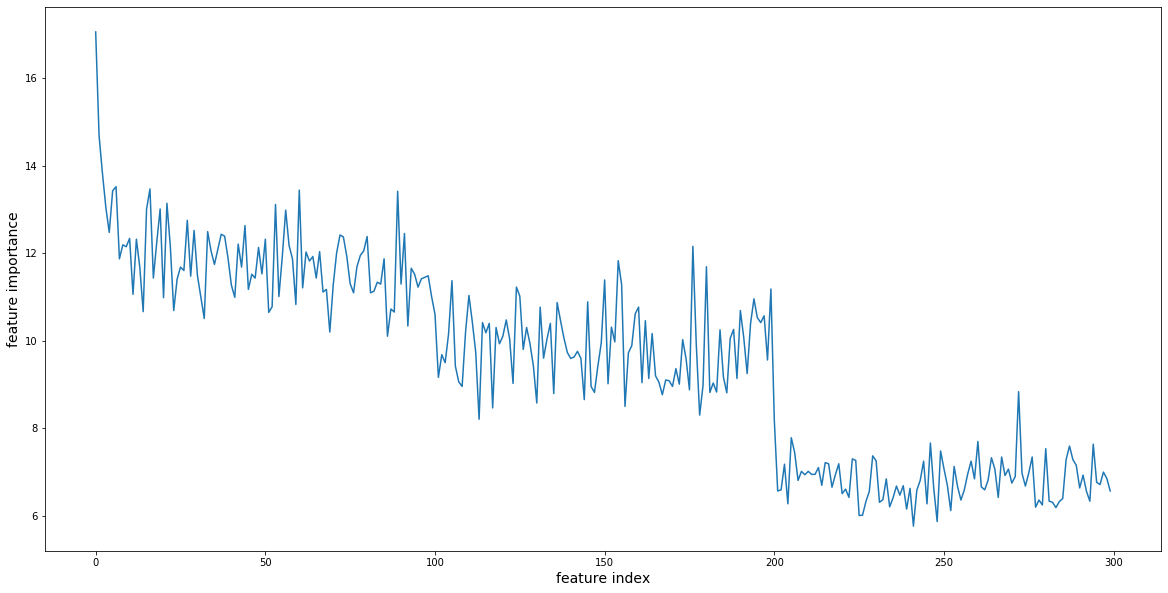

In [73]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_random_smiles_bm_fis.png', dpi=100)

In [74]:
plt.close()

### Shuffle SMILES vectors, leaving outputs the same (shuffle SMILES)
Trains model on fake reactions, testing on same test set of real ones

In [75]:
# Show SMILES dataset for comparison
X_train_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,67.0,108.0,67.0,49.0,61.0,67.0,78.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# Shuffle row ordering removing index
X_train_smiles_shuffle = np.random.permutation(X_train_smiles.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_smiles_shuffle_inputs = pd.DataFrame(
    X_train_smiles_shuffle, index=X_train_smiles.index, 
    columns=X_train_smiles.columns
)

# View new dataframe (can see inputs have changed)
X_train_smiles_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,78.0,49.0,78.0,61.0,67.0,40.0,78.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70.0,67.0,49.0,61.0,78.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67.0,67.0,78.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,70.0,67.0,40.0,70.0,41.0,40.0,70.0,41.0,67.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134632,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134633,66.0,114.0,67.0,49.0,61.0,67.0,67.0,50.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134635,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# But indices have stayed the same
X_train_smiles_shuffle_inputs.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            134625, 134626, 134627, 134628, 134630, 134631, 134632, 134633,
            134635, 134636],
           dtype='int64', length=116505)

In [78]:
X_train_smiles.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            134625, 134626, 134627, 134628, 134630, 134631, 134632, 134633,
            134635, 134636],
           dtype='int64', length=116505)

In [79]:
# Check test set
X_test_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
8,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,67.0,67.0,40.0,67.0,41.0,91.0,67.0,64.0,64.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,91.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134607,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134614,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134615,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134629,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Re-train and test model
start_time = time.time()
shuffle_smiles_file = 'shuffle_smiles_bm_gbm.model.joblib'
shuffle_smiles_bm_gbm = train_lgbm_classifier(
    X_train_smiles_shuffle_inputs, y_train, shuffle_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_smiles_bm_preds = shuffle_smiles_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
shuffle_smiles_bm_preds_labeled = get_top_k_preds(
    shuffle_smiles_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_smiles_bm_formatted_results = format_results_for_metrics(
    shuffle_smiles_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_smiles_bm_metrics = get_metrics_dict(
    shuffle_smiles_bm_formatted_results, type_count, 
    'shuffle_smiles_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_smiles_top_1_acc = shuffle_smiles_bm_metrics['top_1_acc']
shuffle_smiles_top_3_acc = shuffle_smiles_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 553.978392124176 s
Top 1 accuracy for type  M  : 0.3841477671264905
Top 3 accuracy for type  M  : 0.6746941002260152
Top 1 accuracy for type  L  : 0.8668069519133349
Top 3 accuracy for type  L  : 0.9221416880991349
Top 1 accuracy for type  B  : 0.3275660509703063
Top 3 accuracy for type  B  : 0.7286259839451329
Top 1 accuracy for type  S  : 0.646247369651625
Top 3 accuracy for type  S  : 0.8014963759644611
Top 1 accuracy for type  A  : 0.928454524199205
Top 3 accuracy for type  A  : 0.9733458031330372


## Fully random inputs (random inputs)
Combine random SMILES and random Mordred inputs

In [81]:
# Re-combine random SMILES and random Mordred dataframes
X_train_random_inputs = pd.concat(
    [X_train_random_smiles, X_train_random_mordred], axis=1
)
X_test_random_inputs = pd.concat(
    [X_test_random_smiles, X_test_random_mordred], axis=1
)

# View new dataframe
X_train_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,25,76,83,42,87,43,88,91,60,102,...,5.080629e+10,3.145491e+10,2.554056e+09,3.849439e+10,2.145370e+10,5.317177e+10,5.781806e+10,4.940370e+10,4.160616e+10,1.819998e+10
1,25,76,83,42,87,43,88,91,60,102,...,6.777353e+10,4.870328e+10,7.486053e+09,1.936695e+10,3.685019e+10,5.714998e+10,6.300131e+10,1.616321e+10,6.139163e+10,3.265799e+10
2,25,76,83,42,87,43,88,91,60,102,...,9.023437e+10,2.550510e+10,5.294985e+10,3.453610e+10,2.646201e+09,4.808108e+10,6.434101e+10,2.631256e+10,4.389925e+10,8.125941e+10
3,25,76,83,42,87,43,88,91,60,102,...,4.574313e+10,8.786967e+10,1.442104e+10,1.119288e+09,4.403084e+10,6.421708e+10,6.572996e+10,6.714904e+10,5.746791e+10,7.950726e+10
4,25,76,83,42,87,43,88,91,60,102,...,3.198902e+10,6.008018e+10,8.715956e+10,9.444766e+10,8.112790e+09,5.149936e+09,7.916261e+10,6.775656e+10,3.938331e+10,4.797440e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,106,89,20,19,101,37,46,91,52,73,...,7.082005e+10,8.755874e+10,2.789384e+10,8.143554e+10,4.051321e+10,5.709108e+10,7.674242e+10,1.378313e+10,4.554659e+10,6.193368e+10
134632,76,8,49,37,110,110,20,42,81,114,...,3.281488e+10,1.348807e+10,3.385876e+10,3.547967e+10,2.057452e+09,2.829037e+10,6.503726e+10,5.145290e+10,1.199171e+10,9.510853e+10
134633,44,109,77,15,54,6,92,31,21,109,...,7.871161e+10,2.334886e+10,3.656899e+10,4.742807e+10,5.271948e+10,6.572171e+10,6.318786e+10,1.676327e+10,7.702186e+10,2.470339e+10
134635,27,9,82,91,14,85,105,95,101,39,...,1.638443e+10,2.178268e+10,3.847355e+08,2.849655e+10,4.017432e+10,6.772914e+09,6.506965e+10,9.550305e+10,7.194931e+10,3.016546e+10


In [82]:
# Compare to original dataset
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,3,3.230594,2,1.313878,0.0,0,0,11.466447,0,11.257379
1,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,2,82.999986,0,1.587710,0.0,0,0,0.000000,0,11.126903
2,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,1,1.249326,1,1.346440,0.0,0,0,11.466447,0,11.257379
3,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,12.695387,0,0.262041,0.0,0,0,0.000000,0,11.257379
4,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,0,0.000000,0,0.244082,0.0,0,0,0.000000,0,10.440599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134631,67.0,108.0,67.0,49.0,61.0,67.0,78.0,61.0,67.0,67.0,...,0,1.879398,0,0.156780,0.0,0,0,0.000000,0,0.000000
134632,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,1.888657,0,0.327483,0.0,0,0,0.000000,0,11.126903
134633,67.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,67.0,...,0,0.000000,0,0.322449,0.0,0,0,0.000000,0,11.126903
134635,67.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,66.0,...,0,1.652014,0,0.764308,0.0,0,0,5.687386,0,11.257379


In [83]:
X_test_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
8,25,76,83,42,87,43,88,91,60,102,...,5.406265e+10,9.373029e+10,9.326952e+10,6.669954e+10,2.082653e+10,2.575569e+10,6.442734e+10,1.061616e+10,2.990137e+09,2.093546e+10
28,107,22,40,58,37,72,49,9,64,55,...,6.910493e+09,9.308324e+10,7.676313e+10,2.021418e+09,6.992513e+10,9.514948e+10,7.147241e+10,2.890198e+10,9.524582e+09,3.238568e+10
29,54,35,68,79,107,12,96,31,103,27,...,5.755699e+10,2.404178e+10,4.070395e+10,2.308397e+09,3.504773e+10,4.387886e+10,9.295885e+10,3.055662e+10,4.701745e+10,4.497120e+10
65,62,45,112,113,24,57,75,103,80,29,...,1.147714e+10,9.286396e+10,3.330157e+10,8.700046e+09,2.529964e+10,7.031174e+10,1.773576e+10,9.243064e+10,6.061229e+10,7.575446e+10
100,66,5,34,98,56,83,52,32,53,19,...,7.601065e+09,3.855876e+10,7.184891e+10,1.635133e+10,1.249490e+10,3.408638e+10,6.930060e+10,4.436457e+10,1.126645e+10,7.643200e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134607,83,13,101,106,104,76,77,85,110,20,...,4.686483e+10,5.817005e+10,4.089101e+10,9.300125e+09,8.405795e+09,2.237365e+10,8.624414e+10,7.061194e+10,8.938915e+10,5.584763e+09
134614,96,111,26,97,62,106,54,88,62,35,...,3.635141e+10,2.029556e+10,6.257655e+10,7.385801e+10,2.017385e+10,4.382368e+10,7.388976e+10,2.275559e+10,3.228077e+09,6.443675e+10
134615,107,33,65,59,66,0,93,6,14,19,...,6.180744e+10,3.191047e+10,7.690203e+10,6.113829e+10,3.071839e+10,8.391120e+09,1.451300e+10,5.626160e+10,1.719399e+10,4.906573e+09
134629,20,10,58,105,94,73,34,82,48,5,...,4.717929e+10,7.941179e+10,3.151300e+10,4.455415e+10,9.563138e+10,3.414875e+10,2.973029e+10,3.026110e+10,1.438753e+10,4.401372e+10


In [84]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
8,67.0,79.0,67.0,40.0,61.0,79.0,41.0,67.0,49.0,61.0,...,1,1.799630,0,1.232063,0.0,0,0,0.000000,0,28.133794
28,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0,0.000000,0,0.667755,0.0,0,0,5.907180,0,16.876415
29,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,0,0.000000,0,0.933878,0.0,0,0,11.594566,0,16.876415
65,67.0,67.0,40.0,67.0,41.0,91.0,67.0,64.0,64.0,93.0,...,0,3.246661,0,1.417370,0.0,0,0,5.559267,0,28.071669
100,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,91.0,83.0,...,0,24.748169,0,1.063810,0.0,0,0,0.000000,0,11.126903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134607,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,5.216139,0,0.180408,0.0,0,0,0.000000,0,0.000000
134614,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,2.368521,0,1.383175,0.0,0,0,0.000000,0,16.876415
134615,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,2.791429,0.0,0,0,5.687386,0,11.126903
134629,79.0,66.0,40.0,79.0,41.0,67.0,49.0,61.0,67.0,67.0,...,2,0.000000,0,1.569116,0.0,0,0,0.000000,0,16.876415


In [85]:
# Re-train and test model
start_time = time.time()
random_inputs_file = 'random_inputs_bm_gbm.model.joblib'
random_inputs_bm_gbm = train_lgbm_classifier(
    X_train_random_inputs, y_train, random_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_inputs_preds = random_inputs_bm_gbm.predict_proba(
    X_test_random_inputs
)

# Get top-k predicted rankings from prediction set
random_inputs_preds_labeled = get_top_k_preds(
    random_inputs_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_inputs_formatted_results = format_results_for_metrics(
    random_inputs_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_inputs_metrics = get_metrics_dict(
    random_inputs_formatted_results, type_count, 'random_inputs_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_inputs_top_1_acc = random_inputs_metrics['top_1_acc']
random_inputs_top_3_acc = random_inputs_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 6961.963989973068 s
Top 1 accuracy for type  M  : 0.5202244563946692
Top 3 accuracy for type  M  : 0.8297092977944042
Top 1 accuracy for type  L  : 0.7887148312680228
Top 3 accuracy for type  L  : 0.9545631673291248
Top 1 accuracy for type  B  : 0.45288753799392095
Top 3 accuracy for type  B  : 0.8092120645312134
Top 1 accuracy for type  S  : 0.6594965318369573
Top 3 accuracy for type  S  : 0.8623645857688411
Top 1 accuracy for type  A  : 0.7588652482269503
Top 3 accuracy for type  A  : 0.9812173641960876


### Feature importances

In [86]:
num_estimators = len(random_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_inputs_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('suzuki_random_inputs_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['0', '1', '2', '3', '180', '7', '38', '33', '89', '4', '9', '176', '37',
       '79', '5', '19', '63', '58', '13', '10'],
      dtype='object')
Index(['0', '1', '2', '3', '180', '7', '38', '33', '89', '4', '9', '176', '37',
       '79', '5', '19', '63', '13', '58', '10'],
      dtype='object')
Index(['rdfred_2_fragCpx', 'rdfred_1_SlogP_VSA5', 'rdfred_1_piPC2',
       'rdfred_1_n9FAHRing', 'rdfred_1_nFHRing', 'rdfred_1_naHRing',
       'rdfred_1_ATSC5dv', 'rdfred_1_n10FaHRing', 'rdfred_1_SRW10',
       'rdfred_2_ATS2dv', 'rdfred_1_SMR_VSA5', 'rdfred_1_ATS6se',
       'rdfred_2_ATSC7pe', 'rdfred_1_ATSC6d', 'rdfred_1_nBondsKD',
       'rdfred_1_ATSC1i', 'rdfred_1_ATS4se', 'rdfred_1_CIC3',
       'rdfred_1_PEOE_VSA1', 'rdfred_2_ATS0i'],
      dtype='object')


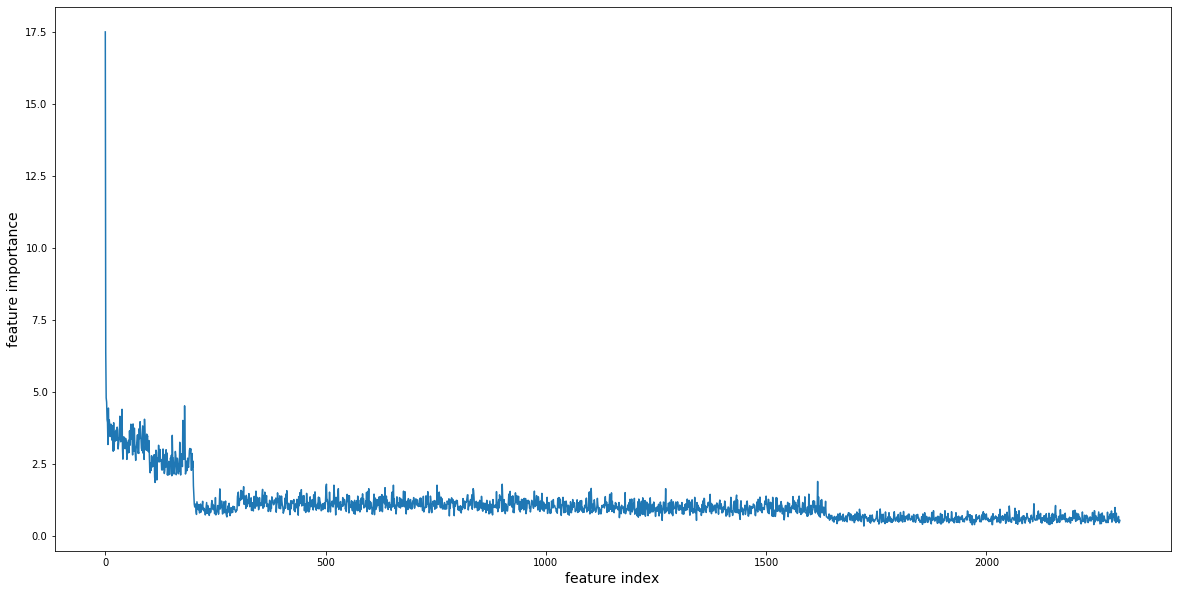

In [87]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_random_inputs_fis.png', dpi=100)

In [88]:
plt.close()

## Classifier trellis method (CT)

In [89]:
def train_one_lgbm_classifier(X_train, y_train):
    """
    Trains one LightGBM binary classifier for a single bin in the label space.
    Differs from train_lgbm_classifier as is not wrapped in a
    OneVsRestClassifier and does not add single classifiers to joblib.
    Model parameters are otherwise identical
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    clf = LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    )
    clf.fit(X_train, y_train)
    return clf


class ClassifierTrellis:
    def __init__(self, struct, fit_func):
        self.struct = struct
        self.fit_func = fit_func
        self.width = len(struct)
        self.clfs = [[None for col in range(self.width)]
                     for row in range(self.width)]
    
    def create_X_trellis(self, X, Y, row, col):
        """
        Forms trellis structure at given position in grid with propagation
        directions from label dependency matrix
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (int)row: current row index
            (int)col: current column index
            
        RETURNS:
            (pandas.DataFrame)X_trellis: trellis structure at given position
            in grid
        """
        # Set empty label propagation matrix
        n_rows = len(X)
        dep_Y = pd.DataFrame({
            'topleft': np.zeros(n_rows),
            'left': np.zeros(n_rows),
            'top': np.zeros(n_rows)
        }, index=X.index)

        # Fill in dependency matrix with output labels in each applicable
        # propagation direction
        if row > 0:
            dep_Y['top'] = Y[self.struct[row - 1][col][1]]
        if col > 0:
            dep_Y['left'] = Y[self.struct[row][col - 1][1]]
        if row > 0 and col > 0:
            dep_Y['topleft'] = Y[self.struct[row - 1][col - 1][1]]
        
        # Append label values to input vectors
        X_trellis = X.merge(dep_Y, left_index=True, right_index=True)
        return X_trellis

    def fit(self, X, Y, train_on_predictions=False):
        """
        Fits a classifier for each label in the trellis
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (Bool)train_on_predictions: whether to append predicted or 
            ground truth labels as the propagated inputs in training
            
        RETURNS:
            self.clfs will be fit to training data
        """
        # Set empty dataframe to fill in predicted outputs
        preds_df = pd.DataFrame(index=X.index)
        
        # Iterate through the trellis updating inputs and fitting classifiers
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                # Get current label bin to be predicted
                target_col = self.struct[row][col][1]
                if train_on_predictions:
                    # Use predictions to make trellis columns
                    X_trellis = self.create_X_trellis(X, preds_df, row, col)
                else:
                    # Use ground truth to make trellis columns
                    X_trellis = self.create_X_trellis(X, Y, row, col)
                #print("Training clf at ({}, {}) called: {}".format(row, col, target_col))
                # Train classifier for current label with updated inputs
                self.clfs[row][col] = self.fit_func(X_trellis, Y[target_col])

                # Update prediction set with outputs from current classifier
                if train_on_predictions:
                    # Create predictions for use in training
                    #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                    col_preds = self.clfs[row][col].predict_proba(X_trellis)
                    preds_df[target_col] = col_preds[:,1]

        
    def predict(self, X):
        """
        Make predictions using trellis classifiers
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            
        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = col_preds[:,1]
        return preds_df
    
    def predict_on_zeros(self, X):
        """
        Make predictions using trellis classifiers removing propagated inputs

        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe

        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = np.zeros(col_preds[:,1].shape)
        return preds_df

## Full CT model
### Trained on propagated predictions

In [90]:
# Construct classifier trellis
suzuki_ct = ClassifierTrellis(struct, train_one_lgbm_classifier)

# Train CT model
start_time = time.time()
suzuki_ct.fit(X_train, y_train, train_on_predictions=True)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Save CT model
joblib.dump(suzuki_ct, 'suzuki_ct_gbms.model.joblib')

# Make predictions with trained model
ct_full_preds = suzuki_ct.predict(X_test)

# Re-index to match dictionary order
ct_full_preds = ct_full_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
ct_full_preds_labeled = get_top_k_preds(
    ct_full_preds.values, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
ct_full_formatted_results = format_results_for_metrics(
    ct_full_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
ct_full_metrics = get_metrics_dict(
    ct_full_formatted_results, type_count, 'ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
ct_full_top_1_acc = ct_full_metrics['top_1_acc']
ct_full_top_3_acc = ct_full_metrics['top_k_acc']

Training complete. Training time: 7338.852714061737 s
Top 1 accuracy for type  M  : 0.5629335203803288
Top 3 accuracy for type  M  : 0.8474787623723794
Top 1 accuracy for type  L  : 0.8407762450315642
Top 3 accuracy for type  L  : 0.9605642584365989
Top 1 accuracy for type  B  : 0.4777492011534565
Top 3 accuracy for type  B  : 0.8249551866573143
Top 1 accuracy for type  S  : 0.6750837814667602
Top 3 accuracy for type  S  : 0.8576884108799002
Top 1 accuracy for type  A  : 0.9195697919102175
Top 3 accuracy for type  A  : 0.983243706647962


### Control withholding predictions

In [91]:
# Make predictions with no propagated values
zero_input_ct_preds = suzuki_ct.predict_on_zeros(X_test)

# Re-index to match dictionary order
zero_input_ct_preds = zero_input_ct_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
zero_input_ct_preds_labeled = get_top_k_preds(
    zero_input_ct_preds.values, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
zero_input_ct_formatted_results = format_results_for_metrics(
    zero_input_ct_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
zero_input_ct_metrics = get_metrics_dict(
    zero_input_ct_formatted_results, type_count, 'zero_input_ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
zero_input_ct_top_1_acc = zero_input_ct_metrics['top_1_acc']
zero_input_ct_top_3_acc = zero_input_ct_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.3966955030784818
Top 3 accuracy for type  M  : 0.39809835554516404
Top 1 accuracy for type  L  : 0.030161328033668458
Top 3 accuracy for type  L  : 0.03249941547813888
Top 1 accuracy for type  B  : 0.33294365209258825
Top 3 accuracy for type  B  : 0.33504793079261164
Top 1 accuracy for type  S  : 0.11425453978645468
Top 3 accuracy for type  S  : 0.3110435663627153
Top 1 accuracy for type  A  : 0.021744213233574936
Top 3 accuracy for type  A  : 0.023770555685449304


### Feature importances

In [92]:
all_fis = []

for i in range(len(suzuki_ct.clfs)):
    for j in range(len(suzuki_ct.clfs[i])):
        try:
            fis_ij = suzuki_ct.clfs[i][j].feature_importances_
            smiles_fis_ij = fis_ij[:300].tolist()
            mordred_fis_ij = fis_ij[300:2304].tolist()
            reagent_fis_ij = fis_ij[2304:].tolist()
            avg_reagent_fis_ij = [(np.average(np.array(reagent_fis_ij)))]
            full_fis_ij = smiles_fis_ij + mordred_fis_ij + avg_reagent_fis_ij
            all_fis.append(full_fis_ij)
        except:
            continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:2304]
reagent_fis = average_fis[2304:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

#fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('suzuki_ct_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

#top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fis)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

[2304  201    6   11   13    9  110   10    5    0    7    3  111    1
   16    4   12  213    8  210]
Index(['201', '6', '11', '13', '9', '110', '10', '5', '0', '7', '3', '111',
       '1', '16', '4', '12', '213', '8', '210', '15'],
      dtype='object')
Index(['rdfred_1_ATSC3m', 'product_SdssC', 'rdfred_2_SdssC', 'rdfred_1_JGI3',
       'product_JGI6', 'product_JGI3', 'rdfred_1_SsCl', 'product_JGI5',
       'rdfred_1_IC0', 'product_SlogP_VSA8', 'product_IC1', 'rdfred_1_AATSC0p',
       'product_JGI9', 'product_JGI4', 'rdfred_2_SsOH', 'rdfred_1_EState_VSA6',
       'product_fMF', 'product_JGI8', 'rdfred_1_AATSC0i', 'product_IC2'],
      dtype='object')


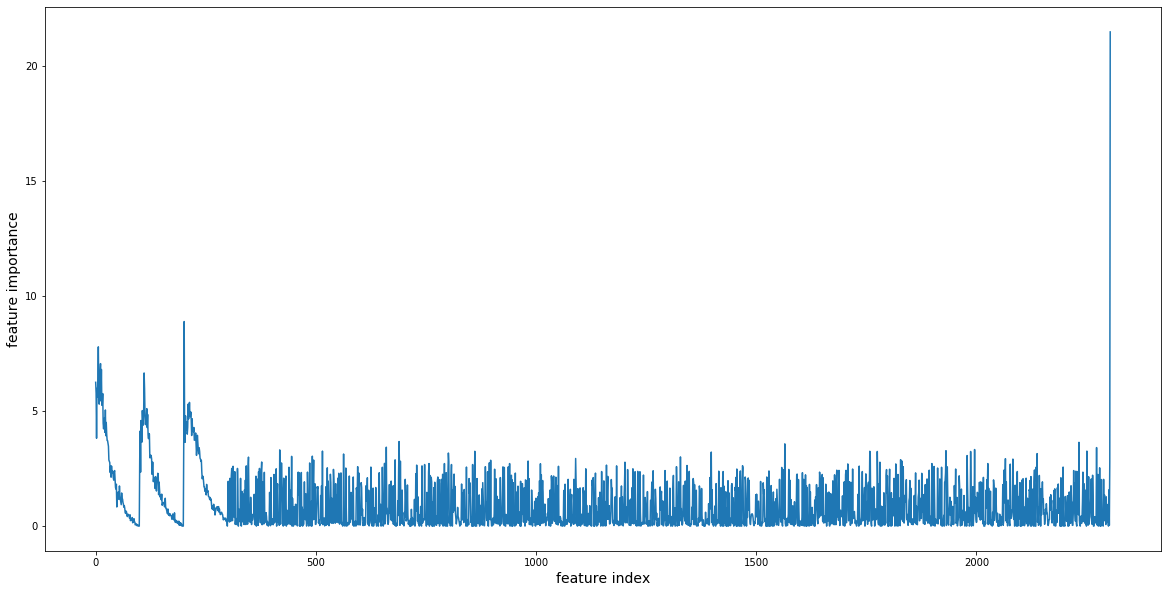

In [93]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('suzuki_full_ct_fis.png', dpi=100)

In [94]:
plt.close()

## Dummy model

In [95]:
# Train model
start_time = time.time()
dummy_model_file = 'dummy_model.joblib'
dummy_clf = train_lgbm_classifier(
    np.zeros((len(y_train), 2)), y_train, dummy_model_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
dummy_preds = dummy_clf.predict_proba(
    np.zeros((len(y_test), 2))
)

# Get top-k predicted rankings from prediction set
dummy_preds_labeled = get_top_k_preds(
    dummy_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
dummy_formatted_results = format_results_for_metrics(
    dummy_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
dummy_metrics = get_metrics_dict(
    dummy_formatted_results, type_count, 'dummy_metrics.json'
)

# View top-1 and top-3 accuracy metrics
dummy_top_1_acc = dummy_metrics['top_1_acc']
dummy_top_3_acc = dummy_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 93 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))


Training complete. Training time: 16.03899908065796 s
Top 1 accuracy for type  M  : 0.3966955030784818
Top 3 accuracy for type  M  : 0.6771880601667836
Top 1 accuracy for type  L  : 0.8778738991504949
Top 3 accuracy for type  L  : 0.9277530979658639
Top 1 accuracy for type  B  : 0.33294365209258825
Top 3 accuracy for type  B  : 0.7384459512119087
Top 1 accuracy for type  S  : 0.646481178396072
Top 3 accuracy for type  S  : 0.8079650845608293
Top 1 accuracy for type  A  : 0.9476268412438625
Top 3 accuracy for type  A  : 0.9754500818330606
